In [14]:
import numpy as np
import pandas as pd
import random
import sys, os, multiprocessing, csv
import matplotlib.pyplot as plt
import urllib
from io import BytesIO
import re
import tqdm
from PIL import Image

In [2]:
links = pd.read_csv("train/new_train.csv", error_bad_lines=False)

In [3]:
links.head()

,Unnamed: 0,id,url,landmark_id
0,71043,775f9f71f0eb2300,https://lh3.googleusercontent.com/-dBd90XSEK_s...,4638
1,198668,48cfe8e287326153,https://lh5.googleusercontent.com/-pGiva-OhD_Y...,11139
2,98678,eb9817a6d8f31d6a,http://lh5.ggpht.com/-iZ-llS7AlaY/SIwzn_zZU5I/...,6051
3,219466,38f6b5ee91b46361,http://lh4.ggpht.com/-9WtalDcCZsU/RfKTGvQzSuI/...,12571
4,90802,1aebc94ed4be585f,http://mw2.google.com/mw-panoramio/photos/medi...,5754


In [11]:
links = links.drop(['Unnamed: 0'], axis = 1)

In [12]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250810 entries, 0 to 250809
Data columns (total 3 columns):
id             250810 non-null object
url            250810 non-null object
landmark_id    250810 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.7+ MB


In [13]:
links.describe()

,landmark_id
count,250810.000000
mean,7339.273932
std,4033.584384
min,0.000000
25%,4070.000000
50%,7083.000000
75%,10432.000000
max,14950.000000


In [14]:
len(np.unique(links.landmark_id))

14951

Lets take a look how much pictures of different classes are present

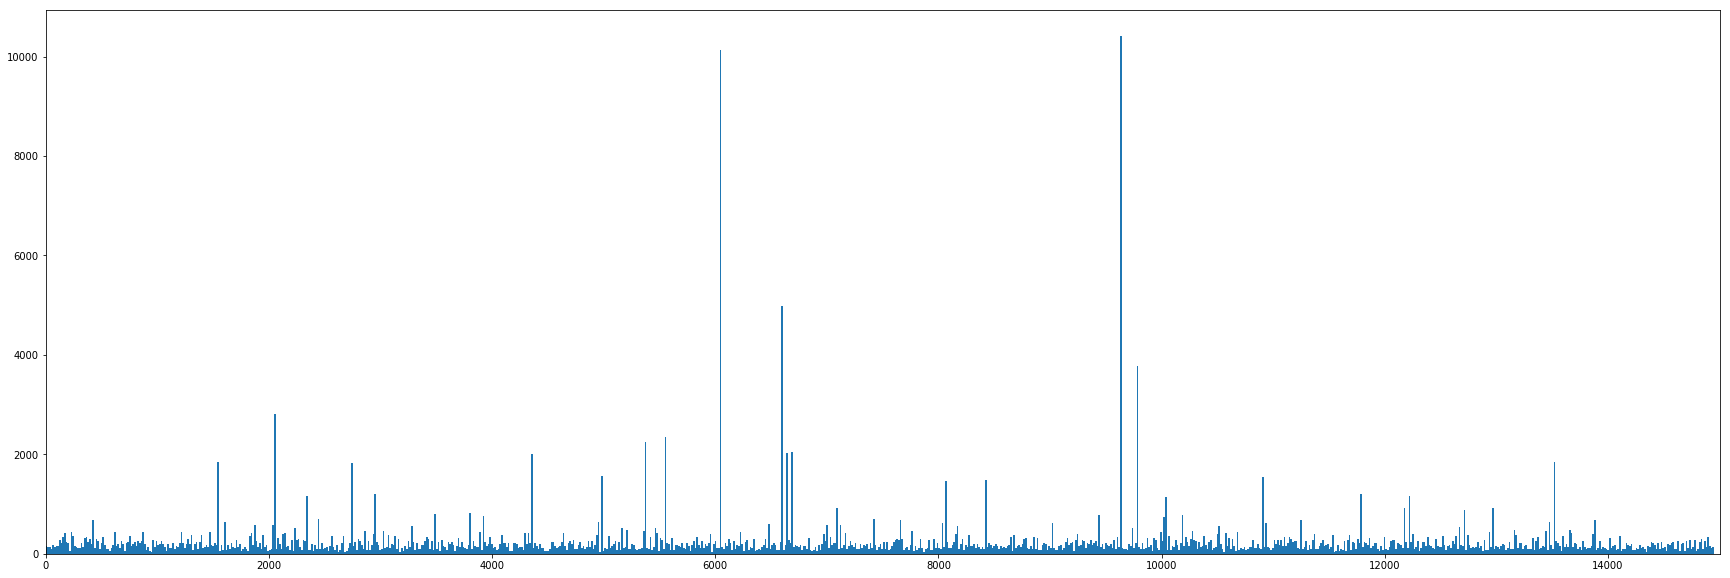

In [15]:
plt.figure(figsize=(30, 10))
plt.hist(links.landmark_id, bins=1000)
plt.xlim((0, 15000))
plt.show()

In [16]:
listik = links.landmark_id.value_counts() > 100

In [17]:
trues = listik[listik == True]
falses = listik[listik == False]

In [18]:
print len(trues)
print len(falses)

382
14569


Our data is still representative. Lets download 600k pictures that are left for training and resize them.

In [19]:
# set files and dir
DATA_FRAME, OUT_DIR = links, './train'

# DATA_FRAME, OUT_DIR = pd.read_csv('./input/test.csv'), './input/test'  # test data

# preferences
TARGET_SIZE = 256  # image resolution to be stored
IMG_QUALITY = 90  # JPG quality
NUM_WORKERS = 8  # Num of CPUs

In [20]:
DATA_FRAME.url.apply(lambda x: x.split('/')[-2]).value_counts().head()

s1600       201301
medium       19679
rj           19191
original      2567
s128          1943
Name: url, dtype: int64

In [10]:
def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)

    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)

    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df


def parse_data(df):
    key_url_list = [line[:2] for line in df.values]
    return key_url_list


def download_image(key_url):
    (key, url) = key_url
    filename = os.path.join(OUT_DIR, '{}.jpg'.format(key))

    if os.path.exists(filename):
        print('Image {} already exists. Skipping download.'.format(filename))
        return 0

    try:
        response = urllib.urlopen(url)
        image_data = response.read()
    except:
        print('Warning: Could not download image {} from {}'.format(key, url))
        return 1

    try:
        pil_image = Image.open(BytesIO(image_data))
    except:
        print('Warning: Failed to parse image {}'.format(key))
        return 1

    try:
        pil_image_rgb = pil_image.convert('RGB')
    except:
        print('Warning: Failed to convert image {} to RGB'.format(key))
        return 1

    try:
        pil_image_resize = pil_image_rgb.resize((TARGET_SIZE, TARGET_SIZE))
    except:
        print('Warning: Failed to resize image {}'.format(key))
        return 1

    try:
        pil_image_resize.save(filename, format='JPEG', quality=IMG_QUALITY)
    except:
        print('Warning: Failed to save image {}'.format(filename))
        return 1

    return 0


def loader(df):
    if not os.path.exists(OUT_DIR):
        os.mkdir(OUT_DIR)

    key_url_list = parse_data(df)
    pool = multiprocessing.Pool(processes=NUM_WORKERS)
    failures = sum(tqdm.tqdm(pool.imap_unordered(download_image, key_url_list),
                             total=len(key_url_list)))
    print('Total number of download failures:', failures)
    pool.close()
    pool.terminate()

In [22]:
if __name__ == '__main__':
    loader(overwrite_urls(DATA_FRAME))

  0%|          | 74/250810 [00:03<3:40:42, 18.93it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  0%|          | 148/250810 [00:07<3:43:04, 18.73it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  0%|          | 601/250810 [00:30<3:34:29, 19.44it/s]

  0%|          | 1151/250810 [00:58<3:30:58, 19.72it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  1%|          | 1305/250810 [01:06<3:31:28, 19.66it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  1%|          | 1609/250810 [01:21<3:31:12, 19.66it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  1%|          | 1768/250810 [01:29<3:30:15, 19.74it/s]

  1%|          | 2446/250810 [02:02<3:27:14, 19.97it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  1%|          | 2468/250810 [02:03<3:27:34, 19.94it/s]

  1%|▏         | 3379/250810 [02:51<3:29:29, 19.69it/s]

  2%|▏         | 4720/250810 [04:06<3:34:00, 19.16it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  2%|▏         | 4878/250810 [04:14<3:33:49, 19.17it/s]

  2%|▏         | 5190/250810 [04:29<3:32:51, 19.23it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  2%|▏         | 5274/250810 [04:35<3:33:44, 19.15it/s]

  2%|▏         | 5849/250810 [05:06<3:33:46, 19.10it/s]

  4%|▍         | 9797/250810 [08:33<3:30:31, 19.08it/s]

  4%|▍         | 10748/250810 [09:22<3:29:29, 19.10it/s]

  5%|▌         | 13660/250810 [11:47<3:24:41, 19.31it/s]

  7%|▋         | 17623/250810 [15:11<3:21:07, 19.32it/s]

  7%|▋         | 17756/250810 [15:20<3:21:18, 19.30it/s]

  7%|▋         | 17837/250810 [15:25<3:21:27, 19.27it/s]

  8%|▊         | 18953/250810 [16:23<3:20:28, 19.28it/s]

  8%|▊         | 19291/250810 [16:40<3:20:07, 19.28it/s]

  9%|▉         | 22490/250810 [19:21<3:16:34, 19.36it/s]

  9%|▉         | 22708/250810 [19:32<3:16:19, 19.37it/s]

  9%|▉         | 23570/250810 [20:14<3:15:12, 19.40it/s]

 10%|▉         | 24502/250810 [21:00<3:14:05, 19.43it/s]

 12%|█▏        | 30930/250810 [26:35<3:09:02, 19.39it/s]

 12%|█▏        | 31330/250810 [26:55<3:08:36, 19.39it/s]

 13%|█▎        | 32043/250810 [27:31<3:07:56, 19.40it/s]

 13%|█▎        | 32131/250810 [27:36<3:07:51, 19.40it/s]

 13%|█▎        | 33391/250810 [28:42<3:06:55, 19.38it/s]

 14%|█▍        | 35246/250810 [30:24<3:05:56, 19.32it/s]

 14%|█▍        | 35353/250810 [30:30<3:05:54, 19.32it/s]

 14%|█▍        | 35610/250810 [30:45<3:05:52, 19.30it/s]

 15%|█▌        | 38428/250810 [33:18<3:04:07, 19.22it/s]

 16%|█▌        | 39465/250810 [34:16<3:03:31, 19.19it/s]

 16%|█▌        | 39586/250810 [34:22<3:03:23, 19.20it/s]

 17%|█▋        | 43385/250810 [37:45<3:00:29, 19.15it/s]

 18%|█▊        | 46170/250810 [40:18<2:58:38, 19.09it/s]

 20%|██        | 50210/250810 [43:46<2:54:51, 19.12it/s]

 21%|██        | 51893/250810 [45:11<2:53:13, 19.14it/s]

 21%|██▏       | 53556/250810 [46:37<2:51:44, 19.14it/s]

 22%|██▏       | 54430/250810 [47:22<2:50:54, 19.15it/s]

 22%|██▏       | 54976/250810 [47:50<2:50:26, 19.15it/s]

 24%|██▎       | 59200/250810 [51:29<2:46:40, 19.16it/s]

 24%|██▍       | 59850/250810 [52:01<2:46:00, 19.17it/s]

 24%|██▍       | 59941/250810 [52:06<2:45:56, 19.17it/s]

 24%|██▍       | 61108/250810 [53:07<2:44:55, 19.17it/s]

 25%|██▍       | 62645/250810 [54:27<2:43:35, 19.17it/s]

 25%|██▌       | 62920/250810 [54:42<2:43:22, 19.17it/s]

 25%|██▌       | 63215/250810 [54:58<2:43:07, 19.17it/s]

 26%|██▌       | 65445/250810 [56:52<2:41:04, 19.18it/s]

 27%|██▋       | 67564/250810 [58:37<2:39:00, 19.21it/s]

 27%|██▋       | 68439/250810 [59:23<2:38:16, 19.20it/s]

 27%|██▋       | 68491/250810 [59:26<2:38:13, 19.20it/s]

 27%|██▋       | 68678/250810 [59:36<2:38:03, 19.21it/s]

 28%|██▊       | 70622/250810 [1:01:19<2:36:27, 19.20it/s]

 28%|██▊       | 71221/250810 [1:01:53<2:36:02, 19.18it/s]

 29%|██▊       | 71797/250810 [1:02:20<2:35:26, 19.19it/s]

 29%|██▉       | 72153/250810 [1:02:38<2:35:06, 19.20it/s]

 29%|██▉       | 73458/250810 [1:03:47<2:34:01, 19.19it/s]

 30%|██▉       | 75239/250810 [1:05:24<2:32:37, 19.17it/s]

 31%|███       | 77231/250810 [1:07:07<2:30:51, 19.18it/s]

 31%|███       | 77252/250810 [1:07:08<2:30:50, 19.18it/s]

 31%|███       | 77480/250810 [1:07:20<2:30:38, 19.18it/s]

 32%|███▏      | 80537/250810 [1:09:58<2:27:56, 19.18it/s]

 32%|███▏      | 80574/250810 [1:10:00<2:27:54, 19.18it/s]

 32%|███▏      | 80669/250810 [1:10:04<2:27:48, 19.18it/s]

 32%|███▏      | 80822/250810 [1:10:12<2:27:40, 19.19it/s]

 33%|███▎      | 81641/250810 [1:10:56<2:26:59, 19.18it/s]

 34%|███▍      | 84768/250810 [1:13:36<2:24:11, 19.19it/s]

 36%|███▌      | 89281/250810 [1:17:30<2:20:12, 19.20it/s]

 37%|███▋      | 93223/250810 [1:20:59<2:16:54, 19.18it/s]

 37%|███▋      | 93646/250810 [1:21:21<2:16:32, 19.18it/s]

 38%|███▊      | 94088/250810 [1:21:43<2:16:08, 19.19it/s]

 38%|███▊      | 94318/250810 [1:21:55<2:15:55, 19.19it/s]

 38%|███▊      | 94368/250810 [1:21:57<2:15:52, 19.19it/s]

 38%|███▊      | 94554/250810 [1:22:06<2:15:42, 19.19it/s]

 38%|███▊      | 94632/250810 [1:22:11<2:15:38, 19.19it/s]

 39%|███▉      | 98502/250810 [1:25:39<2:12:26, 19.17it/s]

 39%|███▉      | 98525/250810 [1:25:40<2:12:24, 19.17it/s]

 41%|████▏     | 103504/250810 [1:30:08<2:08:17, 19.14it/s]

 42%|████▏     | 105491/250810 [1:31:49<2:06:29, 19.15it/s]

 44%|████▍     | 109987/250810 [1:35:46<2:02:38, 19.14it/s]

 44%|████▍     | 110864/250810 [1:36:32<2:01:51, 19.14it/s]

 44%|████▍     | 111469/250810 [1:37:03<2:01:20, 19.14it/s]

 45%|████▍     | 112591/250810 [1:38:01<2:00:20, 19.14it/s]

 45%|████▌     | 113021/250810 [1:38:22<1:59:55, 19.15it/s]

 45%|████▌     | 113282/250810 [1:38:35<1:59:41, 19.15it/s]

 46%|████▌     | 114706/250810 [1:39:46<1:58:23, 19.16it/s]

 47%|████▋     | 117470/250810 [1:42:08<1:55:56, 19.17it/s]

 47%|████▋     | 118190/250810 [1:42:43<1:55:16, 19.17it/s]

 47%|████▋     | 118345/250810 [1:42:51<1:55:08, 19.18it/s]

 48%|████▊     | 120090/250810 [1:44:23<1:53:37, 19.17it/s]

 48%|████▊     | 120405/250810 [1:44:39<1:53:21, 19.17it/s]

 48%|████▊     | 120789/250810 [1:45:01<1:53:03, 19.17it/s]

 49%|████▉     | 123083/250810 [1:47:08<1:51:11, 19.15it/s]

 49%|████▉     | 124112/250810 [1:48:01<1:50:17, 19.15it/s]

 52%|█████▏    | 130315/250810 [1:53:25<1:44:52, 19.15it/s]

 53%|█████▎    | 131703/250810 [1:54:37<1:43:40, 19.15it/s]

 53%|█████▎    | 132417/250810 [1:55:14<1:43:02, 19.15it/s]

 53%|█████▎    | 133317/250810 [1:56:01<1:42:14, 19.15it/s]

 55%|█████▍    | 137456/250810 [1:59:35<1:38:36, 19.16it/s]

 56%|█████▌    | 139727/250810 [2:01:36<1:36:41, 19.15it/s]

 56%|█████▌    | 139932/250810 [2:01:50<1:36:32, 19.14it/s]

 56%|█████▌    | 140014/250810 [2:01:54<1:36:28, 19.14it/s]

 56%|█████▌    | 140160/250810 [2:02:02<1:36:20, 19.14it/s]

 56%|█████▌    | 140452/250810 [2:02:15<1:36:03, 19.15it/s]

 56%|█████▋    | 141122/250810 [2:02:49<1:35:28, 19.15it/s]

 56%|█████▋    | 141333/250810 [2:03:01<1:35:17, 19.15it/s]

 57%|█████▋    | 143016/250810 [2:04:29<1:33:50, 19.15it/s]

 59%|█████▊    | 147281/250810 [2:08:05<1:30:02, 19.16it/s]

 59%|█████▉    | 148984/250810 [2:09:29<1:28:30, 19.18it/s]

 61%|██████    | 152056/250810 [2:12:11<1:25:50, 19.17it/s]

 61%|██████    | 152771/250810 [2:12:47<1:25:13, 19.17it/s]

 61%|██████    | 153198/250810 [2:13:12<1:24:52, 19.17it/s]

 61%|██████    | 153479/250810 [2:13:27<1:24:37, 19.17it/s]

 62%|██████▏   | 154271/250810 [2:14:10<1:23:57, 19.16it/s]

 62%|██████▏   | 154296/250810 [2:14:11<1:23:56, 19.16it/s]

 62%|██████▏   | 154553/250810 [2:14:25<1:23:42, 19.16it/s]

 62%|██████▏   | 155656/250810 [2:15:23<1:22:45, 19.16it/s]

 63%|██████▎   | 156863/250810 [2:16:26<1:21:43, 19.16it/s]

 63%|██████▎   | 156880/250810 [2:16:27<1:21:42, 19.16it/s]

 63%|██████▎   | 157097/250810 [2:16:37<1:21:30, 19.16it/s]

 63%|██████▎   | 157813/250810 [2:17:15<1:20:53, 19.16it/s]

 63%|██████▎   | 158137/250810 [2:17:33<1:20:37, 19.16it/s]

 65%|██████▍   | 162243/250810 [2:21:05<1:17:01, 19.17it/s]

 66%|██████▌   | 164396/250810 [2:22:59<1:15:09, 19.16it/s]

 66%|██████▌   | 164548/250810 [2:23:07<1:15:01, 19.16it/s]

 66%|██████▌   | 164625/250810 [2:23:11<1:14:57, 19.16it/s]

 67%|██████▋   | 167095/250810 [2:25:19<1:12:48, 19.16it/s]

 69%|██████▊   | 171919/250810 [2:29:29<1:08:36, 19.17it/s]

 69%|██████▊   | 172212/250810 [2:29:44<1:08:20, 19.17it/s]

 69%|██████▉   | 173066/250810 [2:30:25<1:07:34, 19.18it/s]

 69%|██████▉   | 173972/250810 [2:31:15<1:06:48, 19.17it/s]

 70%|██████▉   | 174473/250810 [2:31:41<1:06:22, 19.17it/s]

 70%|███████   | 176642/250810 [2:33:41<1:04:31, 19.16it/s]

 71%|███████   | 178387/250810 [2:35:11<1:03:00, 19.16it/s]

 71%|███████▏  | 178919/250810 [2:35:40<1:02:32, 19.16it/s]

 73%|███████▎  | 182469/250810 [2:38:47<59:28, 19.15it/s]  

 74%|███████▍  | 186702/250810 [2:42:30<55:48, 19.15it/s]

 75%|███████▌  | 188747/250810 [2:44:16<54:01, 19.15it/s]

 76%|███████▌  | 190215/250810 [2:45:35<52:45, 19.14it/s]

 76%|███████▋  | 191555/250810 [2:46:46<51:35, 19.14it/s]

 77%|███████▋  | 193075/250810 [2:48:04<50:15, 19.15it/s]

 77%|███████▋  | 193114/250810 [2:48:06<50:13, 19.15it/s]

 77%|███████▋  | 193192/250810 [2:48:09<50:09, 19.15it/s]

 78%|███████▊  | 196453/250810 [2:50:50<47:16, 19.17it/s]

 79%|███████▉  | 199039/250810 [2:52:58<44:59, 19.18it/s]

 80%|███████▉  | 200153/250810 [2:53:52<44:00, 19.19it/s]

 80%|████████  | 201113/250810 [2:54:41<43:10, 19.19it/s]

 80%|████████  | 201864/250810 [2:55:18<42:30, 19.19it/s]

 81%|████████  | 202458/250810 [2:55:49<41:59, 19.19it/s]

 81%|████████  | 203280/250810 [2:56:29<41:16, 19.20it/s]

 82%|████████▏ | 204528/250810 [2:57:33<40:10, 19.20it/s]

 83%|████████▎ | 207320/250810 [2:59:54<37:44, 19.21it/s]

 83%|████████▎ | 207702/250810 [3:00:14<37:24, 19.21it/s]

 83%|████████▎ | 209228/250810 [3:01:32<36:04, 19.21it/s]

 84%|████████▍ | 211065/250810 [3:03:09<34:29, 19.21it/s]

 84%|████████▍ | 211644/250810 [3:03:38<33:58, 19.21it/s]

 85%|████████▍ | 212000/250810 [3:03:56<33:40, 19.21it/s]

 85%|████████▌ | 213243/250810 [3:04:59<32:35, 19.21it/s]

 85%|████████▌ | 213949/250810 [3:05:33<31:58, 19.22it/s]

 86%|████████▌ | 214991/250810 [3:06:27<31:03, 19.22it/s]

 86%|████████▌ | 216263/250810 [3:07:30<29:57, 19.22it/s]

 87%|████████▋ | 217015/250810 [3:08:07<29:17, 19.23it/s]

 88%|████████▊ | 220662/250810 [3:11:05<26:06, 19.25it/s]

 91%|█████████▏| 228926/250810 [3:17:50<18:54, 19.29it/s]

 91%|█████████▏| 229259/250810 [3:18:07<18:37, 19.29it/s]

 92%|█████████▏| 230459/250810 [3:19:11<17:35, 19.28it/s]

 92%|█████████▏| 231109/250810 [3:19:44<17:01, 19.28it/s]

 92%|█████████▏| 231524/250810 [3:20:06<16:40, 19.28it/s]

 93%|█████████▎| 233111/250810 [3:21:24<15:17, 19.29it/s]

 93%|█████████▎| 233137/250810 [3:21:25<15:16, 19.29it/s]

 93%|█████████▎| 233446/250810 [3:21:39<14:59, 19.29it/s]

 93%|█████████▎| 233767/250810 [3:21:55<14:43, 19.30it/s]

 94%|█████████▍| 235811/250810 [3:23:39<12:57, 19.30it/s]

 95%|█████████▌| 238875/250810 [3:26:15<10:18, 19.30it/s]

 95%|█████████▌| 239017/250810 [3:26:23<10:11, 19.30it/s]

 96%|█████████▌| 240147/250810 [3:27:22<09:12, 19.30it/s]

 96%|█████████▌| 241400/250810 [3:28:30<08:07, 19.30it/s]

 96%|█████████▋| 241629/250810 [3:28:41<07:55, 19.30it/s]

 98%|█████████▊| 245690/250810 [3:31:58<04:25, 19.32it/s]

 98%|█████████▊| 246468/250810 [3:32:36<03:44, 19.32it/s]

 99%|█████████▉| 247753/250810 [3:33:38<02:38, 19.33it/s]

 99%|█████████▉| 248079/250810 [3:33:53<02:21, 19.33it/s]

 99%|█████████▉| 248659/250810 [3:34:23<01:51, 19.33it/s]/usr/local/lib/python2.7/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python2.7/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))
100%|█████████▉| 249966/250810 [3:35:26<00:43, 19.34it/s]

100%|██████████| 250810/250810 [3:36:08<00:00, 19.34it/s]

('Total number of download failures:', 180)


Now lets download and resize test data

In [2]:
tests = pd.read_csv("test.csv", error_bad_lines=False)

In [3]:
tests.head()

,id,url
0,000088da12d664db,https://lh3.googleusercontent.com/-k45wfamuhT8...
1,0001623c6d808702,https://lh3.googleusercontent.com/-OQ0ywv8KVIA...
2,0001bbb682d45002,https://lh3.googleusercontent.com/-kloLenz1xZk...
3,0002362830cfe3a3,https://lh3.googleusercontent.com/-N6z79jNZYTg...
4,000270c9100de789,https://lh3.googleusercontent.com/-keriHaVOq1U...


In [4]:
# set files and dir
DATA_FRAME, OUT_DIR = tests, './data/test'

# preferences
TARGET_SIZE = 256  # image resolution to be stored
IMG_QUALITY = 90  # JPG quality
NUM_WORKERS = 8  # Num of CPUs

In [7]:
if __name__ == '__main__':
    loader(overwrite_urls(DATA_FRAME))

  0%|          | 40/117703 [00:00<32:32, 60.25it/s] /usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  0%|          | 226/117703 [00:03<29:02, 67.43it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  0%|          | 436/117703 [00:06<31:04, 62.89it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  0%|          | 442/117703 [00:07<31:08, 62.76it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  0%|          | 456/117703 [00:07<31:12, 62.63it/s]

  0%|          | 479/117703 [00:07<31:09, 62.69it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  0%|          | 486/117703 [00:07<31:10, 62.67it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  1%|          | 790/117703 [00:12<29:51, 65.28it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  1%|          | 1104/117703 [00:16<29:11, 66.58it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
  2%|▏         | 2649/117703 [00:38<27:32, 69.62it/s]

 21%|██        | 24896/117703 [05:57<22:14, 69.57it/s]

 29%|██▊       | 33653/117703 [08:04<20:09, 69.49it/s]

 29%|██▊       | 33772/117703 [08:06<20:08, 69.48it/s]

 35%|███▌      | 41682/117703 [10:00<18:15, 69.42it/s]

 36%|███▌      | 42600/117703 [10:13<18:01, 69.45it/s]

 45%|████▌     | 53418/117703 [12:53<15:30, 69.08it/s]

 48%|████▊     | 56013/117703 [13:31<14:54, 68.99it/s]

 74%|███████▍  | 86953/117703 [21:09<07:29, 68.47it/s]

 77%|███████▋  | 91173/117703 [22:14<06:28, 68.30it/s]

 79%|███████▉  | 92695/117703 [22:36<06:05, 68.35it/s]

 83%|████████▎ | 97870/117703 [23:49<04:49, 68.47it/s]

 99%|█████████▉| 117043/117703 [28:48<00:09, 67.70it/s]

100%|██████████| 117703/117703 [29:01<00:00, 67.59it/s]

('Total number of download failures:', 14)


Now lets download validation

In [22]:
vals = pd.read_csv("val_data.csv", error_bad_lines=False)

In [23]:
vals = vals.drop(["Unnamed: 0"], axis=1)

In [24]:
vals.head()

,id,url,landmark_id
0,d39eec4fd20f94fb,http://lh6.ggpht.com/-rqwSifo7yC8/TMNNi-PfgrI/...,0
1,f4e5819b9ee83792,https://lh6.googleusercontent.com/-limoWy6SNU4...,0
2,8ba2feb9b479aee6,http://mw2.google.com/mw-panoramio/photos/medi...,1
3,f8b4331969d03317,https://lh4.googleusercontent.com/-SV8d91LWi_Q...,2
4,71eddd5f7e86e51d,https://lh3.googleusercontent.com/-UscAcEayyzE...,3


In [25]:
# set files and dir
DATA_FRAME, OUT_DIR = vals, './data/val'

# preferences
TARGET_SIZE = 256  # image resolution to be stored
IMG_QUALITY = 90  # JPG quality
NUM_WORKERS = 8  # Num of CPUs

In [26]:
if __name__ == '__main__':
    loader(overwrite_urls(DATA_FRAME))



  0%|          | 0/34472 [00:00<?, ?it/s]

  0%|          | 1/34472 [00:00<1:31:42,  6.26it/s]

  0%|          | 3/34472 [00:00<52:04, 11.03it/s]  

  0%|          | 4/34472 [00:00<55:04, 10.43it/s]

  0%|          | 9/34472 [00:00<33:48, 16.99it/s]

  0%|          | 11/34472 [00:00<32:57, 17.43it/s]

  0%|          | 14/34472 [00:00<33:31, 17.13it/s]

  0%|          | 18/34472 [00:00<29:51, 19.23it/s]

  0%|          | 21/34472 [00:01<30:04, 19.10it/s]

  0%|          | 24/34472 [00:01<29:14, 19.63it/s]

  0%|          | 27/34472 [00:01<29:39, 19.35it/s]

  0%|          | 30/34472 [00:01<28:46, 19.95it/s]

  0%|          | 33/34472 [00:01<28:00, 20.50it/s]

  0%|          | 36/34472 [00:01<28:39, 20.03it/s]

  0%|          | 40/34472 [00:01<27:53, 20.57it/s]

  0%|          | 43/34472 [00:02<29:22, 19.54it/s]

  0%|          | 47/34472 [00:02<28:24, 20.20it/s]

  0%|          | 51/34472 [00:02<28:08, 20.39it/s]

  0%|          | 54/34472 [00:02<27:55, 20.54it/s]

  0%|          | 57



  1%|          | 258/34472 [00:13<29:22, 19.42it/s]

  1%|          | 261/34472 [00:13<29:21, 19.42it/s]

  1%|          | 265/34472 [00:13<29:12, 19.52it/s]

  1%|          | 268/34472 [00:13<29:13, 19.51it/s]

  1%|          | 271/34472 [00:13<29:09, 19.55it/s]

  1%|          | 274/34472 [00:14<29:24, 19.38it/s]

  1%|          | 277/34472 [00:14<29:17, 19.45it/s]

  1%|          | 286/34472 [00:14<29:12, 19.50it/s]

  1%|          | 290/34472 [00:14<29:08, 19.55it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


  1%|          | 293/34472 [00:14<29:06, 19.57it/s]

  1%|          | 296/34472 [00:15<29:09, 19.54it/s]

  1%|          | 299/34472 [00:15<29:17, 19.44it/s]

  1%|          | 301/34472 [00:15<29:24, 19.37it/s]

  1%|          | 304/34472 [00:15<29:18, 19.43it/s]

  1%|          | 307/34472 [00:15<29:25, 19.36it/s]

  1%|          | 310/344

  2%|▏         | 740/34472 [00:37<28:26, 19.77it/s]

  2%|▏         | 742/34472 [00:37<28:26, 19.77it/s]

  2%|▏         | 744/34472 [00:37<28:26, 19.77it/s]

  2%|▏         | 746/34472 [00:37<28:26, 19.76it/s]

  2%|▏         | 749/34472 [00:37<28:30, 19.71it/s]

  2%|▏         | 753/34472 [00:38<28:27, 19.75it/s]

  2%|▏         | 758/34472 [00:38<28:21, 19.81it/s]

  2%|▏         | 761/34472 [00:38<28:23, 19.78it/s]

  2%|▏         | 764/34472 [00:38<28:23, 19.79it/s]

  2%|▏         | 767/34472 [00:38<28:26, 19.75it/s]

  2%|▏         | 770/34472 [00:38<28:26, 19.75it/s]

  2%|▏         | 774/34472 [00:39<28:25, 19.76it/s]

  2%|▏         | 777/34472 [00:39<28:26, 19.75it/s]

  2%|▏         | 782/34472 [00:39<28:20, 19.81it/s]

  2%|▏         | 785/34472 [00:39<28:20, 19.81it/s]

  2%|▏         | 788/34472 [00:39<28:21, 19.79it/s]

  2%|▏         | 793/34472 [00:40<28:20, 19.80it/s]

  2%|▏         | 798/34472 [00:40<28:14, 19.88it/s]

  2%|▏         | 802/34472 [00:40<28:09, 19.92

  3%|▎         | 1170/34472 [01:00<28:32, 19.45it/s]



  3%|▎         | 1173/34472 [01:00<28:32, 19.45it/s]

  3%|▎         | 1176/34472 [01:00<28:32, 19.45it/s]

  3%|▎         | 1179/34472 [01:00<28:34, 19.42it/s]

  3%|▎         | 1184/34472 [01:00<28:34, 19.41it/s]

  3%|▎         | 1188/34472 [01:01<28:36, 19.39it/s]

  3%|▎         | 1191/34472 [01:01<28:36, 19.39it/s]

  3%|▎         | 1193/34472 [01:01<28:37, 19.37it/s]

  3%|▎         | 1196/34472 [01:01<28:37, 19.37it/s]

  3%|▎         | 1200/34472 [01:01<28:34, 19.40it/s]

  3%|▎         | 1203/34472 [01:02<28:36, 19.38it/s]

  4%|▎         | 1208/34472 [01:02<28:32, 19.43it/s]

  4%|▎         | 1211/34472 [01:02<28:36, 19.38it/s]

  4%|▎         | 1215/34472 [01:02<28:34, 19.40it/s]

  4%|▎         | 1220/34472 [01:02<28:30, 19.44it/s]

  4%|▎         | 1224/34472 [01:02<28:27, 19.47it/s]

  4%|▎         | 1228/34472 [01:03<28:28, 19.45it/s]

  4%|▎         | 1232/34472 [01:03<28:26, 19.48it/s]

  4%|▎         | 1235/34472 [01:03<28:26, 19.48it/s]

  4%|▎         | 1238/3447

  5%|▍         | 1628/34472 [01:23<28:03, 19.51it/s]

  5%|▍         | 1631/34472 [01:23<28:03, 19.51it/s]

  5%|▍         | 1634/34472 [01:23<28:03, 19.50it/s]

  5%|▍         | 1637/34472 [01:23<28:04, 19.50it/s]

  5%|▍         | 1642/34472 [01:24<28:03, 19.50it/s]

  5%|▍         | 1644/34472 [01:24<28:03, 19.50it/s]

  5%|▍         | 1646/34472 [01:24<28:04, 19.49it/s]

  5%|▍         | 1648/34472 [01:24<28:04, 19.49it/s]

  5%|▍         | 1652/34472 [01:24<28:01, 19.51it/s]

  5%|▍         | 1655/34472 [01:24<28:01, 19.52it/s]

  5%|▍         | 1658/34472 [01:24<28:01, 19.52it/s]

  5%|▍         | 1661/34472 [01:25<28:02, 19.50it/s]

  5%|▍         | 1665/34472 [01:25<28:02, 19.50it/s]

  5%|▍         | 1669/34472 [01:25<28:00, 19.51it/s]

  5%|▍         | 1673/34472 [01:25<27:58, 19.54it/s]

  5%|▍         | 1676/34472 [01:25<27:57, 19.55it/s]

  5%|▍         | 1679/34472 [01:26<27:59, 19.52it/s]

  5%|▍         | 1684/34472 [01:26<27:57, 19.55it/s]

  5%|▍         | 1687/34472 



  5%|▍         | 1709/34472 [01:27<27:52, 19.59it/s]

  5%|▍         | 1712/34472 [01:27<27:54, 19.57it/s]

  5%|▍         | 1717/34472 [01:27<27:51, 19.60it/s]

  5%|▍         | 1720/34472 [01:27<27:50, 19.61it/s]

  5%|▍         | 1723/34472 [01:27<27:50, 19.61it/s]

  5%|▌         | 1726/34472 [01:28<27:50, 19.60it/s]

  5%|▌         | 1733/34472 [01:28<27:49, 19.60it/s]

  5%|▌         | 1736/34472 [01:28<27:49, 19.61it/s]

  5%|▌         | 1739/34472 [01:28<27:49, 19.60it/s]

  5%|▌         | 1742/34472 [01:28<27:50, 19.59it/s]

  5%|▌         | 1744/34472 [01:29<27:50, 19.59it/s]

  5%|▌         | 1747/34472 [01:29<27:50, 19.59it/s]

  5%|▌         | 1749/34472 [01:29<27:51, 19.58it/s]

  5%|▌         | 1752/34472 [01:29<27:50, 19.59it/s]

  5%|▌         | 1755/34472 [01:29<27:50, 19.59it/s]

  5%|▌         | 1759/34472 [01:29<27:50, 19.58it/s]

  5%|▌         | 1763/34472 [01:29<27:48, 19.60it/s]

  5%|▌         | 1766/34472 [01:30<27:50, 19.58it/s]

  5%|▌         | 1769/3447



  6%|▌         | 2053/34472 [01:43<27:18, 19.79it/s]

  6%|▌         | 2056/34472 [01:44<27:20, 19.76it/s]

  6%|▌         | 2060/34472 [01:44<27:18, 19.78it/s]

  6%|▌         | 2063/34472 [01:44<27:20, 19.76it/s]

  6%|▌         | 2068/34472 [01:44<27:18, 19.78it/s]

  6%|▌         | 2071/34472 [01:44<27:19, 19.77it/s]

  6%|▌         | 2075/34472 [01:44<27:19, 19.77it/s]

  6%|▌         | 2079/34472 [01:45<27:17, 19.78it/s]

  6%|▌         | 2082/34472 [01:45<27:16, 19.79it/s]

  6%|▌         | 2085/34472 [01:45<27:16, 19.79it/s]

  6%|▌         | 2088/34472 [01:45<27:16, 19.79it/s]

  6%|▌         | 2091/34472 [01:45<27:18, 19.77it/s]

  6%|▌         | 2095/34472 [01:45<27:16, 19.78it/s]

  6%|▌         | 2098/34472 [01:46<27:16, 19.79it/s]

  6%|▌         | 2101/34472 [01:46<27:16, 19.78it/s]

  6%|▌         | 2104/34472 [01:46<27:19, 19.75it/s]

  6%|▌         | 2109/34472 [01:46<27:17, 19.77it/s]

  6%|▌         | 2113/34472 [01:46<27:16, 19.77it/s]

  6%|▌         | 2116/3447



  7%|▋         | 2358/34472 [01:58<26:57, 19.86it/s]

  7%|▋         | 2361/34472 [01:58<26:57, 19.86it/s]

  7%|▋         | 2364/34472 [01:59<26:58, 19.84it/s]

  7%|▋         | 2367/34472 [01:59<26:57, 19.85it/s]

  7%|▋         | 2370/34472 [01:59<26:58, 19.83it/s]

  7%|▋         | 2372/34472 [01:59<26:59, 19.82it/s]

  7%|▋         | 2378/34472 [01:59<26:56, 19.85it/s]

  7%|▋         | 2382/34472 [02:00<26:57, 19.85it/s]

  7%|▋         | 2388/34472 [02:00<26:54, 19.87it/s]

  7%|▋         | 2391/34472 [02:00<26:57, 19.84it/s]

  7%|▋         | 2395/34472 [02:00<26:55, 19.85it/s]

  7%|▋         | 2398/34472 [02:00<26:58, 19.82it/s]

  7%|▋         | 2402/34472 [02:01<26:57, 19.83it/s]

  7%|▋         | 2405/34472 [02:01<26:56, 19.84it/s]

  7%|▋         | 2409/34472 [02:01<26:55, 19.85it/s]

  7%|▋         | 2412/34472 [02:01<26:56, 19.83it/s]

  7%|▋         | 2417/34472 [02:01<26:54, 19.85it/s]

  7%|▋         | 2420/34472 [02:01<26:54, 19.85it/s]

  7%|▋         | 2423/3447

  8%|▊         | 2813/34472 [02:21<26:27, 19.94it/s]

  8%|▊         | 2816/34472 [02:21<26:27, 19.93it/s]

  8%|▊         | 2822/34472 [02:21<26:26, 19.95it/s]

  8%|▊         | 2825/34472 [02:21<26:26, 19.95it/s]

  8%|▊         | 2829/34472 [02:21<26:26, 19.95it/s]

  8%|▊         | 2832/34472 [02:21<26:25, 19.95it/s]

  8%|▊         | 2836/34472 [02:22<26:25, 19.95it/s]

  8%|▊         | 2839/34472 [02:22<26:25, 19.96it/s]

  8%|▊         | 2844/34472 [02:22<26:24, 19.96it/s]

  8%|▊         | 2847/34472 [02:22<26:24, 19.96it/s]

  8%|▊         | 2853/34472 [02:22<26:22, 19.98it/s]

  8%|▊         | 2856/34472 [02:22<26:22, 19.98it/s]

  8%|▊         | 2859/34472 [02:23<26:22, 19.97it/s]

  8%|▊         | 2862/34472 [02:23<26:22, 19.97it/s]

  8%|▊         | 2866/34472 [02:23<26:21, 19.99it/s]

  8%|▊         | 2869/34472 [02:23<26:21, 19.98it/s]

  8%|▊         | 2872/34472 [02:23<26:22, 19.97it/s]

  8%|▊         | 2875/34472 [02:23<26:21, 19.97it/s]

  8%|▊         | 2878/34472 

  9%|▉         | 3252/34472 [02:43<26:11, 19.87it/s]

  9%|▉         | 3255/34472 [02:43<26:10, 19.88it/s]

  9%|▉         | 3259/34472 [02:43<26:09, 19.89it/s]

  9%|▉         | 3262/34472 [02:44<26:09, 19.88it/s]

  9%|▉         | 3266/34472 [02:44<26:09, 19.88it/s]

  9%|▉         | 3269/34472 [02:44<26:09, 19.88it/s]

  9%|▉         | 3272/34472 [02:44<26:09, 19.88it/s]

 10%|▉         | 3275/34472 [02:44<26:09, 19.87it/s]

 10%|▉         | 3279/34472 [02:44<26:09, 19.88it/s]

 10%|▉         | 3282/34472 [02:45<26:10, 19.86it/s]

 10%|▉         | 3284/34472 [02:45<26:11, 19.85it/s]

 10%|▉         | 3289/34472 [02:45<26:10, 19.85it/s]

 10%|▉         | 3292/34472 [02:45<26:10, 19.86it/s]

 10%|▉         | 3295/34472 [02:45<26:09, 19.86it/s]

 10%|▉         | 3298/34472 [02:46<26:10, 19.85it/s]

 10%|▉         | 3300/34472 [02:46<26:10, 19.85it/s]

 10%|▉         | 3302/34472 [02:46<26:10, 19.84it/s]

 10%|▉         | 3304/34472 [02:46<26:10, 19.84it/s]

 10%|▉         | 3306/34472 



 11%|█         | 3652/34472 [03:03<25:47, 19.92it/s]

 11%|█         | 3655/34472 [03:03<25:47, 19.92it/s]

 11%|█         | 3659/34472 [03:03<25:46, 19.93it/s]

 11%|█         | 3662/34472 [03:03<25:45, 19.93it/s]

 11%|█         | 3665/34472 [03:03<25:45, 19.93it/s]/usr/local/lib/python2.7/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 11%|█         | 3669/34472 [03:04<25:45, 19.94it/s]

 11%|█         | 3672/34472 [03:04<25:44, 19.94it/s]

 11%|█         | 3675/34472 [03:04<25:44, 19.93it/s]

 11%|█         | 3678/34472 [03:04<25:44, 19.94it/s]

 11%|█         | 3681/34472 [03:04<25:45, 19.93it/s]

 11%|█         | 3685/34472 [03:04<25:44, 19.94it/s]

 11%|█         | 3688/34472 [03:04<25:44, 19.94it/s]

 11%|█         | 3692/34472 [03:05<25:43, 19.94it/s]

 11%|█         | 3695/34472 [03:05<25:43, 19.94it/s]

 11%|█         | 3698/34472 [03:05<25:44, 19.93it/s]

 11%|█   



 11%|█         | 3768/34472 [03:09<25:41, 19.92it/s]

 11%|█         | 3771/34472 [03:09<25:42, 19.91it/s]

 11%|█         | 3773/34472 [03:09<25:42, 19.91it/s]

 11%|█         | 3776/34472 [03:09<25:42, 19.91it/s]

 11%|█         | 3780/34472 [03:09<25:41, 19.91it/s]

 11%|█         | 3783/34472 [03:09<25:41, 19.91it/s]

 11%|█         | 3786/34472 [03:10<25:40, 19.92it/s]

 11%|█         | 3789/34472 [03:10<25:40, 19.92it/s]

 11%|█         | 3792/34472 [03:10<25:40, 19.92it/s]

 11%|█         | 3795/34472 [03:10<25:39, 19.92it/s]

 11%|█         | 3798/34472 [03:10<25:40, 19.91it/s]

 11%|█         | 3800/34472 [03:10<25:41, 19.90it/s]

 11%|█         | 3805/34472 [03:11<25:40, 19.91it/s]

 11%|█         | 3808/34472 [03:11<25:41, 19.89it/s]

 11%|█         | 3811/34472 [03:11<25:40, 19.90it/s]

 11%|█         | 3816/34472 [03:11<25:39, 19.91it/s]

 11%|█         | 3819/34472 [03:11<25:39, 19.91it/s]

 11%|█         | 3822/34472 [03:11<25:39, 19.91it/s]

 11%|█         | 3826/3447

 12%|█▏        | 4227/34472 [03:31<25:11, 20.00it/s]

 12%|█▏        | 4230/34472 [03:31<25:12, 19.99it/s]

 12%|█▏        | 4233/34472 [03:31<25:12, 19.99it/s]

 12%|█▏        | 4236/34472 [03:31<25:13, 19.98it/s]

 12%|█▏        | 4241/34472 [03:32<25:11, 20.00it/s]

 12%|█▏        | 4245/34472 [03:32<25:11, 20.00it/s]

 12%|█▏        | 4248/34472 [03:32<25:10, 20.00it/s]

 12%|█▏        | 4252/34472 [03:32<25:10, 20.01it/s]

 12%|█▏        | 4256/34472 [03:32<25:09, 20.02it/s]

 12%|█▏        | 4259/34472 [03:32<25:09, 20.02it/s]

 12%|█▏        | 4262/34472 [03:32<25:09, 20.02it/s]

 12%|█▏        | 4265/34472 [03:33<25:08, 20.02it/s]

 12%|█▏        | 4268/34472 [03:33<25:08, 20.02it/s]

 12%|█▏        | 4271/34472 [03:33<25:08, 20.02it/s]

 12%|█▏        | 4274/34472 [03:33<25:08, 20.02it/s]

 12%|█▏        | 4278/34472 [03:33<25:07, 20.02it/s]

 12%|█▏        | 4281/34472 [03:33<25:07, 20.03it/s]

 12%|█▏        | 4285/34472 [03:33<25:07, 20.03it/s]

 12%|█▏        | 4288/34472 

 14%|█▎        | 4664/34472 [03:53<24:52, 19.97it/s]

 14%|█▎        | 4667/34472 [03:53<24:52, 19.97it/s]

 14%|█▎        | 4670/34472 [03:53<24:52, 19.97it/s]

 14%|█▎        | 4673/34472 [03:54<24:52, 19.96it/s]

 14%|█▎        | 4678/34472 [03:54<24:51, 19.97it/s]

 14%|█▎        | 4681/34472 [03:54<24:51, 19.97it/s]

 14%|█▎        | 4684/34472 [03:54<24:51, 19.97it/s]

 14%|█▎        | 4687/34472 [03:54<24:51, 19.97it/s]

 14%|█▎        | 4690/34472 [03:54<24:51, 19.96it/s]

 14%|█▎        | 4693/34472 [03:55<24:51, 19.97it/s]

 14%|█▎        | 4696/34472 [03:55<24:51, 19.96it/s]

 14%|█▎        | 4699/34472 [03:55<24:51, 19.96it/s]

 14%|█▎        | 4702/34472 [03:55<24:51, 19.96it/s]

 14%|█▎        | 4708/34472 [03:55<24:50, 19.97it/s]

 14%|█▎        | 4711/34472 [03:55<24:50, 19.97it/s]

 14%|█▎        | 4716/34472 [03:56<24:49, 19.98it/s]

 14%|█▎        | 4719/34472 [03:56<24:49, 19.98it/s]

 14%|█▎        | 4722/34472 [03:56<24:49, 19.98it/s]

 14%|█▎        | 4725/34472 



 15%|█▍        | 5008/34472 [04:10<24:36, 19.96it/s]

 15%|█▍        | 5012/34472 [04:11<24:36, 19.95it/s]

 15%|█▍        | 5014/34472 [04:11<24:36, 19.95it/s]

 15%|█▍        | 5020/34472 [04:11<24:35, 19.96it/s]

 15%|█▍        | 5023/34472 [04:11<24:35, 19.96it/s]

 15%|█▍        | 5026/34472 [04:11<24:36, 19.95it/s]

 15%|█▍        | 5033/34472 [04:12<24:34, 19.96it/s]

 15%|█▍        | 5036/34472 [04:12<24:34, 19.96it/s]

 15%|█▍        | 5040/34472 [04:12<24:33, 19.97it/s]

 15%|█▍        | 5043/34472 [04:12<24:34, 19.96it/s]

 15%|█▍        | 5047/34472 [04:12<24:33, 19.97it/s]

 15%|█▍        | 5050/34472 [04:12<24:33, 19.97it/s]

 15%|█▍        | 5053/34472 [04:12<24:32, 19.97it/s]

 15%|█▍        | 5056/34472 [04:13<24:33, 19.97it/s]

 15%|█▍        | 5059/34472 [04:13<24:33, 19.97it/s]

 15%|█▍        | 5062/34472 [04:13<24:33, 19.96it/s]

 15%|█▍        | 5066/34472 [04:13<24:32, 19.97it/s]

 15%|█▍        | 5069/34472 [04:13<24:33, 19.96it/s]

 15%|█▍        | 5074/3447

 16%|█▌        | 5475/34472 [04:33<24:08, 20.02it/s]

 16%|█▌        | 5478/34472 [04:33<24:07, 20.03it/s]

 16%|█▌        | 5481/34472 [04:33<24:07, 20.03it/s]

 16%|█▌        | 5486/34472 [04:33<24:06, 20.04it/s]

 16%|█▌        | 5489/34472 [04:33<24:06, 20.04it/s]

 16%|█▌        | 5492/34472 [04:34<24:06, 20.04it/s]

 16%|█▌        | 5495/34472 [04:34<24:06, 20.03it/s]

 16%|█▌        | 5498/34472 [04:34<24:06, 20.03it/s]

 16%|█▌        | 5501/34472 [04:34<24:06, 20.03it/s]

 16%|█▌        | 5504/34472 [04:34<24:06, 20.03it/s]

 16%|█▌        | 5507/34472 [04:34<24:05, 20.03it/s]

 16%|█▌        | 5511/34472 [04:35<24:05, 20.03it/s]

 16%|█▌        | 5514/34472 [04:35<24:05, 20.03it/s]

 16%|█▌        | 5520/34472 [04:35<24:04, 20.04it/s]

 16%|█▌        | 5524/34472 [04:35<24:04, 20.04it/s]

 16%|█▌        | 5527/34472 [04:35<24:04, 20.03it/s]

 16%|█▌        | 5530/34472 [04:36<24:04, 20.03it/s]

 16%|█▌        | 5533/34472 [04:36<24:04, 20.03it/s]

 16%|█▌        | 5536/34472 

 17%|█▋        | 5927/34472 [04:55<23:43, 20.06it/s]

 17%|█▋        | 5930/34472 [04:55<23:43, 20.05it/s]

 17%|█▋        | 5932/34472 [04:55<23:43, 20.05it/s]

 17%|█▋        | 5937/34472 [04:56<23:42, 20.06it/s]

 17%|█▋        | 5940/34472 [04:56<23:43, 20.05it/s]

 17%|█▋        | 5943/34472 [04:56<23:42, 20.05it/s]

 17%|█▋        | 5946/34472 [04:56<23:42, 20.05it/s]

 17%|█▋        | 5949/34472 [04:56<23:42, 20.05it/s]

 17%|█▋        | 5953/34472 [04:56<23:42, 20.05it/s]

 17%|█▋        | 5956/34472 [04:57<23:42, 20.05it/s]

 17%|█▋        | 5959/34472 [04:57<23:42, 20.05it/s]

 17%|█▋        | 5965/34472 [04:57<23:40, 20.06it/s]

 17%|█▋        | 5969/34472 [04:57<23:41, 20.06it/s]

 17%|█▋        | 5973/34472 [04:57<23:40, 20.06it/s]

 17%|█▋        | 5976/34472 [04:58<23:41, 20.05it/s]

 17%|█▋        | 5980/34472 [04:58<23:40, 20.05it/s]

 17%|█▋        | 5983/34472 [04:58<23:40, 20.05it/s]

 17%|█▋        | 5987/34472 [04:58<23:40, 20.05it/s]

 17%|█▋        | 5990/34472 

 18%|█▊        | 6371/34472 [05:18<23:24, 20.01it/s]

 18%|█▊        | 6374/34472 [05:18<23:24, 20.01it/s]

 18%|█▊        | 6377/34472 [05:18<23:24, 20.01it/s]

 19%|█▊        | 6381/34472 [05:18<23:23, 20.01it/s]

 19%|█▊        | 6383/34472 [05:19<23:23, 20.01it/s]

 19%|█▊        | 6386/34472 [05:19<23:23, 20.00it/s]

 19%|█▊        | 6388/34472 [05:19<23:23, 20.00it/s]

 19%|█▊        | 6391/34472 [05:19<23:23, 20.01it/s]

 19%|█▊        | 6393/34472 [05:19<23:23, 20.00it/s]

 19%|█▊        | 6396/34472 [05:19<23:23, 20.00it/s]

 19%|█▊        | 6400/34472 [05:19<23:22, 20.01it/s]

 19%|█▊        | 6403/34472 [05:20<23:23, 20.00it/s]

 19%|█▊        | 6406/34472 [05:20<23:23, 20.00it/s]

 19%|█▊        | 6411/34472 [05:20<23:22, 20.01it/s]

 19%|█▊        | 6414/34472 [05:20<23:22, 20.00it/s]

 19%|█▊        | 6418/34472 [05:20<23:22, 20.01it/s]

 19%|█▊        | 6422/34472 [05:20<23:21, 20.01it/s]

 19%|█▊        | 6426/34472 [05:21<23:21, 20.01it/s]

 19%|█▊        | 6429/34472 

 20%|█▉        | 6805/34472 [05:41<23:06, 19.95it/s]

 20%|█▉        | 6808/34472 [05:41<23:06, 19.95it/s]

 20%|█▉        | 6811/34472 [05:41<23:06, 19.95it/s]

 20%|█▉        | 6814/34472 [05:41<23:06, 19.95it/s]

 20%|█▉        | 6819/34472 [05:41<23:05, 19.96it/s]

 20%|█▉        | 6823/34472 [05:41<23:05, 19.96it/s]

 20%|█▉        | 6826/34472 [05:41<23:04, 19.96it/s]

 20%|█▉        | 6830/34472 [05:42<23:04, 19.97it/s]

 20%|█▉        | 6834/34472 [05:42<23:04, 19.96it/s]

 20%|█▉        | 6840/34472 [05:42<23:03, 19.97it/s]

 20%|█▉        | 6844/34472 [05:42<23:03, 19.97it/s]

 20%|█▉        | 6847/34472 [05:42<23:03, 19.97it/s]

 20%|█▉        | 6852/34472 [05:43<23:03, 19.97it/s]

 20%|█▉        | 6855/34472 [05:43<23:02, 19.97it/s]

 20%|█▉        | 6859/34472 [05:43<23:02, 19.98it/s]

 20%|█▉        | 6862/34472 [05:43<23:02, 19.97it/s]

 20%|█▉        | 6865/34472 [05:43<23:01, 19.98it/s]

 20%|█▉        | 6868/34472 [05:43<23:01, 19.98it/s]

 20%|█▉        | 6871/34472 

 21%|██        | 7254/34472 [06:03<22:43, 19.97it/s]

 21%|██        | 7257/34472 [06:03<22:42, 19.97it/s]

 21%|██        | 7261/34472 [06:03<22:43, 19.96it/s]

 21%|██        | 7266/34472 [06:03<22:42, 19.97it/s]

 21%|██        | 7269/34472 [06:04<22:42, 19.97it/s]

 21%|██        | 7272/34472 [06:04<22:42, 19.97it/s]

 21%|██        | 7275/34472 [06:04<22:42, 19.97it/s]

 21%|██        | 7278/34472 [06:04<22:41, 19.97it/s]

 21%|██        | 7281/34472 [06:04<22:41, 19.97it/s]

 21%|██        | 7283/34472 [06:04<22:41, 19.96it/s]

 21%|██        | 7288/34472 [06:04<22:41, 19.97it/s]

 21%|██        | 7291/34472 [06:05<22:41, 19.96it/s]

 21%|██        | 7294/34472 [06:05<22:41, 19.96it/s]

 21%|██        | 7297/34472 [06:05<22:41, 19.96it/s]

 21%|██        | 7300/34472 [06:05<22:41, 19.96it/s]

 21%|██        | 7303/34472 [06:05<22:41, 19.96it/s]

 21%|██        | 7305/34472 [06:05<22:41, 19.96it/s]

 21%|██        | 7308/34472 [06:06<22:40, 19.96it/s]

 21%|██        | 7311/34472 

 22%|██▏       | 7687/34472 [06:25<22:22, 19.95it/s]

 22%|██▏       | 7691/34472 [06:25<22:21, 19.96it/s]

 22%|██▏       | 7694/34472 [06:25<22:22, 19.95it/s]

 22%|██▏       | 7697/34472 [06:25<22:21, 19.95it/s]

 22%|██▏       | 7700/34472 [06:25<22:21, 19.95it/s]

 22%|██▏       | 7704/34472 [06:25<22:21, 19.96it/s]

 22%|██▏       | 7707/34472 [06:26<22:21, 19.96it/s]

 22%|██▏       | 7710/34472 [06:26<22:20, 19.96it/s]

 22%|██▏       | 7713/34472 [06:26<22:21, 19.95it/s]

 22%|██▏       | 7715/34472 [06:26<22:21, 19.95it/s]

 22%|██▏       | 7718/34472 [06:26<22:20, 19.95it/s]

 22%|██▏       | 7721/34472 [06:27<22:20, 19.95it/s]

 22%|██▏       | 7725/34472 [06:27<22:20, 19.95it/s]

 22%|██▏       | 7729/34472 [06:27<22:20, 19.95it/s]

 22%|██▏       | 7732/34472 [06:27<22:20, 19.95it/s]

 22%|██▏       | 7735/34472 [06:27<22:19, 19.95it/s]

 22%|██▏       | 7738/34472 [06:27<22:20, 19.95it/s]

 22%|██▏       | 7743/34472 [06:28<22:19, 19.95it/s]

 22%|██▏       | 7746/34472 

 24%|██▎       | 8119/34472 [06:47<22:01, 19.95it/s]

 24%|██▎       | 8123/34472 [06:47<22:00, 19.95it/s]

 24%|██▎       | 8126/34472 [06:47<22:00, 19.95it/s]

 24%|██▎       | 8129/34472 [06:47<22:00, 19.95it/s]

 24%|██▎       | 8132/34472 [06:47<22:00, 19.95it/s]

 24%|██▎       | 8135/34472 [06:47<22:00, 19.95it/s]

 24%|██▎       | 8138/34472 [06:47<22:00, 19.95it/s]

 24%|██▎       | 8141/34472 [06:48<22:00, 19.95it/s]

 24%|██▎       | 8144/34472 [06:48<21:59, 19.95it/s]

 24%|██▎       | 8147/34472 [06:48<21:59, 19.95it/s]

 24%|██▎       | 8150/34472 [06:48<21:59, 19.95it/s]

 24%|██▎       | 8153/34472 [06:48<21:59, 19.95it/s]

 24%|██▎       | 8159/34472 [06:48<21:58, 19.95it/s]

 24%|██▎       | 8162/34472 [06:49<21:58, 19.95it/s]

 24%|██▎       | 8165/34472 [06:49<21:58, 19.95it/s]

 24%|██▎       | 8168/34472 [06:49<21:58, 19.96it/s]

 24%|██▎       | 8171/34472 [06:49<21:57, 19.96it/s]

 24%|██▎       | 8174/34472 [06:49<21:58, 19.95it/s]

 24%|██▎       | 8178/34472 

 25%|██▍       | 8563/34472 [07:08<21:37, 19.96it/s]

 25%|██▍       | 8566/34472 [07:09<21:37, 19.96it/s]

 25%|██▍       | 8570/34472 [07:09<21:37, 19.96it/s]

 25%|██▍       | 8573/34472 [07:09<21:37, 19.96it/s]

 25%|██▍       | 8577/34472 [07:09<21:37, 19.96it/s]

 25%|██▍       | 8580/34472 [07:09<21:36, 19.96it/s]

 25%|██▍       | 8583/34472 [07:09<21:36, 19.97it/s]

 25%|██▍       | 8586/34472 [07:10<21:36, 19.96it/s]

 25%|██▍       | 8589/34472 [07:10<21:36, 19.96it/s]

 25%|██▍       | 8592/34472 [07:10<21:36, 19.97it/s]

 25%|██▍       | 8595/34472 [07:10<21:36, 19.97it/s]

 25%|██▍       | 8598/34472 [07:10<21:35, 19.97it/s]

 25%|██▍       | 8601/34472 [07:10<21:35, 19.97it/s]

 25%|██▍       | 8604/34472 [07:10<21:35, 19.97it/s]

 25%|██▍       | 8607/34472 [07:11<21:35, 19.97it/s]

 25%|██▍       | 8611/34472 [07:11<21:34, 19.97it/s]

 25%|██▍       | 8614/34472 [07:11<21:34, 19.97it/s]

 25%|██▍       | 8617/34472 [07:11<21:34, 19.97it/s]

 25%|██▌       | 8620/34472 

 26%|██▌       | 9002/34472 [07:31<21:17, 19.93it/s]

 26%|██▌       | 9005/34472 [07:31<21:17, 19.94it/s]

 26%|██▌       | 9008/34472 [07:31<21:17, 19.93it/s]

 26%|██▌       | 9011/34472 [07:32<21:17, 19.93it/s]

 26%|██▌       | 9014/34472 [07:32<21:17, 19.93it/s]

 26%|██▌       | 9019/34472 [07:32<21:16, 19.94it/s]

 26%|██▌       | 9022/34472 [07:32<21:16, 19.93it/s]

 26%|██▌       | 9027/34472 [07:32<21:16, 19.93it/s]

 26%|██▌       | 9032/34472 [07:32<21:15, 19.94it/s]

 26%|██▌       | 9035/34472 [07:33<21:15, 19.94it/s]

 26%|██▌       | 9038/34472 [07:33<21:15, 19.94it/s]

 26%|██▌       | 9041/34472 [07:33<21:15, 19.93it/s]

 26%|██▌       | 9043/34472 [07:33<21:15, 19.93it/s]

 26%|██▌       | 9047/34472 [07:33<21:15, 19.94it/s]

 26%|██▋       | 9050/34472 [07:33<21:15, 19.94it/s]

 26%|██▋       | 9053/34472 [07:34<21:15, 19.94it/s]

 26%|██▋       | 9056/34472 [07:34<21:14, 19.94it/s]

 26%|██▋       | 9060/34472 [07:34<21:14, 19.94it/s]

 26%|██▋       | 9063/34472 

 27%|██▋       | 9432/34472 [07:54<20:58, 19.89it/s]

 27%|██▋       | 9435/34472 [07:54<20:59, 19.88it/s]

 27%|██▋       | 9437/34472 [07:54<20:59, 19.88it/s]

 27%|██▋       | 9440/34472 [07:54<20:59, 19.88it/s]

 27%|██▋       | 9444/34472 [07:54<20:58, 19.88it/s]

 27%|██▋       | 9447/34472 [07:55<20:58, 19.88it/s]

 27%|██▋       | 9450/34472 [07:55<20:58, 19.88it/s]

 27%|██▋       | 9455/34472 [07:55<20:58, 19.88it/s]

 27%|██▋       | 9458/34472 [07:55<20:58, 19.88it/s]

 27%|██▋       | 9461/34472 [07:55<20:57, 19.88it/s]

 27%|██▋       | 9464/34472 [07:55<20:57, 19.88it/s]

 27%|██▋       | 9467/34472 [07:56<20:57, 19.88it/s]

 27%|██▋       | 9471/34472 [07:56<20:57, 19.89it/s]

 27%|██▋       | 9474/34472 [07:56<20:56, 19.89it/s]

 27%|██▋       | 9478/34472 [07:56<20:56, 19.89it/s]

 28%|██▊       | 9482/34472 [07:56<20:56, 19.89it/s]

 28%|██▊       | 9485/34472 [07:56<20:55, 19.89it/s]

 28%|██▊       | 9488/34472 [07:56<20:56, 19.89it/s]

 28%|██▊       | 9491/34472 

 29%|██▊       | 9886/34472 [08:16<20:35, 19.89it/s]

 29%|██▊       | 9889/34472 [08:17<20:35, 19.89it/s]

 29%|██▊       | 9892/34472 [08:17<20:35, 19.89it/s]

 29%|██▊       | 9895/34472 [08:17<20:35, 19.89it/s]

 29%|██▊       | 9898/34472 [08:17<20:35, 19.89it/s]

 29%|██▊       | 9901/34472 [08:17<20:35, 19.89it/s]

 29%|██▊       | 9907/34472 [08:17<20:34, 19.90it/s]

 29%|██▊       | 9910/34472 [08:18<20:34, 19.89it/s]

 29%|██▉       | 9915/34472 [08:18<20:34, 19.90it/s]

 29%|██▉       | 9918/34472 [08:18<20:34, 19.90it/s]

 29%|██▉       | 9923/34472 [08:18<20:33, 19.90it/s]

 29%|██▉       | 9926/34472 [08:18<20:33, 19.90it/s]

 29%|██▉       | 9929/34472 [08:18<20:33, 19.90it/s]

 29%|██▉       | 9932/34472 [08:19<20:33, 19.90it/s]

 29%|██▉       | 9935/34472 [08:19<20:33, 19.90it/s]

 29%|██▉       | 9938/34472 [08:19<20:32, 19.90it/s]

 29%|██▉       | 9943/34472 [08:19<20:32, 19.90it/s]

 29%|██▉       | 9946/34472 [08:19<20:32, 19.90it/s]

 29%|██▉       | 9949/34472 



 30%|██▉       | 10214/34472 [08:33<20:20, 19.88it/s]

 30%|██▉       | 10217/34472 [08:33<20:20, 19.88it/s]

 30%|██▉       | 10221/34472 [08:34<20:20, 19.87it/s]

 30%|██▉       | 10227/34472 [08:34<20:19, 19.88it/s]

 30%|██▉       | 10230/34472 [08:34<20:19, 19.88it/s]

 30%|██▉       | 10233/34472 [08:35<20:19, 19.87it/s]

 30%|██▉       | 10235/34472 [08:35<20:19, 19.87it/s]

 30%|██▉       | 10238/34472 [08:35<20:19, 19.87it/s]

 30%|██▉       | 10241/34472 [08:35<20:19, 19.87it/s]

 30%|██▉       | 10244/34472 [08:35<20:19, 19.87it/s]

 30%|██▉       | 10247/34472 [08:35<20:19, 19.87it/s]

 30%|██▉       | 10250/34472 [08:35<20:19, 19.87it/s]

 30%|██▉       | 10252/34472 [08:36<20:19, 19.87it/s]

 30%|██▉       | 10255/34472 [08:36<20:18, 19.87it/s]

 30%|██▉       | 10258/34472 [08:36<20:18, 19.87it/s]

 30%|██▉       | 10261/34472 [08:36<20:18, 19.87it/s]

 30%|██▉       | 10266/34472 [08:36<20:17, 19.88it/s]

 30%|██▉       | 10269/34472 [08:36<20:18, 19.87it/s]

 30%|██▉

 31%|███       | 10653/34472 [08:56<20:00, 19.85it/s]

 31%|███       | 10656/34472 [08:56<19:59, 19.85it/s]

 31%|███       | 10659/34472 [08:57<19:59, 19.85it/s]

 31%|███       | 10661/34472 [08:57<20:00, 19.84it/s]

 31%|███       | 10665/34472 [08:57<19:59, 19.84it/s]

 31%|███       | 10668/34472 [08:57<19:59, 19.84it/s]

 31%|███       | 10671/34472 [08:57<19:59, 19.84it/s]

 31%|███       | 10673/34472 [08:58<19:59, 19.84it/s]

 31%|███       | 10676/34472 [08:58<19:59, 19.83it/s]

 31%|███       | 10678/34472 [08:58<20:00, 19.83it/s]

 31%|███       | 10681/34472 [08:58<19:59, 19.83it/s]

 31%|███       | 10685/34472 [08:58<19:59, 19.83it/s]

 31%|███       | 10687/34472 [08:59<19:59, 19.83it/s]

 31%|███       | 10689/34472 [08:59<19:59, 19.83it/s]

 31%|███       | 10692/34472 [08:59<19:59, 19.83it/s]

 31%|███       | 10695/34472 [08:59<19:59, 19.83it/s]

 31%|███       | 10698/34472 [08:59<19:58, 19.83it/s]

 31%|███       | 10701/34472 [08:59<19:58, 19.83it/s]

 31%|███  

 32%|███▏      | 11081/34472 [09:19<19:41, 19.81it/s]

 32%|███▏      | 11084/34472 [09:19<19:40, 19.80it/s]

 32%|███▏      | 11087/34472 [09:19<19:40, 19.80it/s]

 32%|███▏      | 11089/34472 [09:20<19:40, 19.80it/s]

 32%|███▏      | 11092/34472 [09:20<19:40, 19.80it/s]

 32%|███▏      | 11095/34472 [09:20<19:40, 19.80it/s]

 32%|███▏      | 11099/34472 [09:20<19:40, 19.80it/s]

 32%|███▏      | 11102/34472 [09:20<19:39, 19.81it/s]

 32%|███▏      | 11105/34472 [09:20<19:40, 19.80it/s]

 32%|███▏      | 11108/34472 [09:20<19:39, 19.80it/s]

 32%|███▏      | 11111/34472 [09:21<19:39, 19.80it/s]

 32%|███▏      | 11115/34472 [09:21<19:39, 19.80it/s]

 32%|███▏      | 11118/34472 [09:21<19:39, 19.80it/s]

 32%|███▏      | 11122/34472 [09:21<19:39, 19.80it/s]

 32%|███▏      | 11125/34472 [09:21<19:39, 19.80it/s]

 32%|███▏      | 11128/34472 [09:22<19:38, 19.80it/s]

 32%|███▏      | 11132/34472 [09:22<19:38, 19.80it/s]

 32%|███▏      | 11135/34472 [09:22<19:38, 19.80it/s]

 32%|███▏ 

 33%|███▎      | 11532/34472 [09:41<19:16, 19.83it/s]

 33%|███▎      | 11536/34472 [09:41<19:16, 19.83it/s]

 33%|███▎      | 11539/34472 [09:41<19:16, 19.83it/s]

 33%|███▎      | 11543/34472 [09:42<19:16, 19.83it/s]

 33%|███▎      | 11547/34472 [09:42<19:16, 19.83it/s]

 34%|███▎      | 11550/34472 [09:42<19:16, 19.83it/s]

 34%|███▎      | 11553/34472 [09:42<19:15, 19.83it/s]

 34%|███▎      | 11556/34472 [09:42<19:15, 19.83it/s]

 34%|███▎      | 11559/34472 [09:42<19:15, 19.83it/s]

 34%|███▎      | 11564/34472 [09:43<19:15, 19.83it/s]

 34%|███▎      | 11567/34472 [09:43<19:15, 19.83it/s]

 34%|███▎      | 11571/34472 [09:43<19:14, 19.83it/s]

 34%|███▎      | 11574/34472 [09:43<19:14, 19.83it/s]

 34%|███▎      | 11577/34472 [09:43<19:14, 19.83it/s]



 34%|███▎      | 11580/34472 [09:43<19:14, 19.83it/s]

 34%|███▎      | 11583/34472 [09:44<19:14, 19.83it/s]

 34%|███▎      | 11588/34472 [09:44<19:13, 19.83it/s]

 34%|███▎      | 11591/34472 [09:44<19:13, 19.83it/s]

 34%|███▎      | 11594/34472 [09:44<19:13, 19.83it/s]

 34%|███▎      | 11598/34472 [09:44<19:13, 19.83it/s]

 34%|███▎      | 11601/34472 [09:44<19:13, 19.83it/s]

 34%|███▎      | 11604/34472 [09:45<19:13, 19.83it/s]

 34%|███▎      | 11608/34472 [09:45<19:13, 19.83it/s]

 34%|███▎      | 11610/34472 [09:45<19:13, 19.83it/s]

 34%|███▎      | 11613/34472 [09:45<19:12, 19.83it/s]

 34%|███▎      | 11615/34472 [09:45<19:12, 19.82it/s]

 34%|███▎      | 11618/34472 [09:46<19:12, 19.82it/s]

 34%|███▎      | 11621/34472 [09:46<19:12, 19.82it/s]

 34%|███▎      | 11625/34472 [09:46<19:12, 19.83it/s]

 34%|███▎      | 11628/34472 [09:46<19:12, 19.82it/s]

 34%|███▎      | 11631/34472 [09:46<19:12, 19.83it/s]

 34%|███▎      | 11634/34472 [09:46<19:12, 19.82it/s]

 34%|███

 35%|███▍      | 12022/34472 [10:05<18:51, 19.84it/s]

 35%|███▍      | 12025/34472 [10:05<18:51, 19.84it/s]

 35%|███▍      | 12028/34472 [10:06<18:51, 19.84it/s]

 35%|███▍      | 12031/34472 [10:06<18:50, 19.84it/s]

 35%|███▍      | 12034/34472 [10:06<18:50, 19.85it/s]

 35%|███▍      | 12037/34472 [10:06<18:50, 19.85it/s]

 35%|███▍      | 12040/34472 [10:06<18:50, 19.85it/s]

 35%|███▍      | 12044/34472 [10:06<18:49, 19.85it/s]

 35%|███▍      | 12047/34472 [10:06<18:49, 19.85it/s]

 35%|███▍      | 12050/34472 [10:07<18:49, 19.84it/s]

 35%|███▍      | 12052/34472 [10:07<18:49, 19.84it/s]

 35%|███▍      | 12054/34472 [10:07<18:49, 19.84it/s]

 35%|███▍      | 12056/34472 [10:07<18:49, 19.84it/s]

 35%|███▍      | 12059/34472 [10:07<18:49, 19.84it/s]

 35%|███▍      | 12063/34472 [10:07<18:49, 19.84it/s]

 35%|███▌      | 12066/34472 [10:08<18:49, 19.84it/s]

 35%|███▌      | 12071/34472 [10:08<18:48, 19.85it/s]

 35%|███▌      | 12074/34472 [10:08<18:48, 19.84it/s]

 35%|███▌ 

 36%|███▌      | 12464/34472 [10:27<18:28, 19.86it/s]

 36%|███▌      | 12467/34472 [10:27<18:28, 19.86it/s]

 36%|███▌      | 12471/34472 [10:27<18:27, 19.86it/s]

 36%|███▌      | 12474/34472 [10:28<18:27, 19.86it/s]

 36%|███▌      | 12477/34472 [10:28<18:27, 19.86it/s]

 36%|███▌      | 12482/34472 [10:28<18:27, 19.86it/s]

 36%|███▌      | 12486/34472 [10:28<18:26, 19.86it/s]

 36%|███▌      | 12489/34472 [10:28<18:26, 19.86it/s]

 36%|███▌      | 12493/34472 [10:28<18:26, 19.86it/s]

 36%|███▌      | 12496/34472 [10:29<18:26, 19.86it/s]

 36%|███▋      | 12499/34472 [10:29<18:26, 19.86it/s]

 36%|███▋      | 12502/34472 [10:29<18:26, 19.86it/s]

 36%|███▋      | 12505/34472 [10:29<18:26, 19.86it/s]

 36%|███▋      | 12507/34472 [10:29<18:26, 19.85it/s]

 36%|███▋      | 12509/34472 [10:30<18:26, 19.85it/s]

 36%|███▋      | 12512/34472 [10:30<18:26, 19.85it/s]

 36%|███▋      | 12514/34472 [10:30<18:26, 19.85it/s]

 36%|███▋      | 12516/34472 [10:30<18:26, 19.85it/s]

 36%|███▋ 

 37%|███▋      | 12892/34472 [10:49<18:07, 19.84it/s]

 37%|███▋      | 12897/34472 [10:49<18:07, 19.85it/s]

 37%|███▋      | 12901/34472 [10:49<18:06, 19.85it/s]

 37%|███▋      | 12904/34472 [10:50<18:06, 19.85it/s]

 37%|███▋      | 12908/34472 [10:50<18:06, 19.85it/s]

 37%|███▋      | 12911/34472 [10:50<18:06, 19.85it/s]

 37%|███▋      | 12914/34472 [10:50<18:06, 19.85it/s]

 37%|███▋      | 12917/34472 [10:50<18:06, 19.85it/s]

 37%|███▋      | 12921/34472 [10:50<18:05, 19.85it/s]

 37%|███▋      | 12924/34472 [10:51<18:05, 19.85it/s]

 38%|███▊      | 12927/34472 [10:51<18:05, 19.85it/s]

 38%|███▊      | 12932/34472 [10:51<18:04, 19.85it/s]

 38%|███▊      | 12935/34472 [10:51<18:04, 19.85it/s]

 38%|███▊      | 12940/34472 [10:51<18:04, 19.86it/s]

 38%|███▊      | 12943/34472 [10:51<18:04, 19.86it/s]

 38%|███▊      | 12946/34472 [10:51<18:04, 19.86it/s]

 38%|███▊      | 12949/34472 [10:52<18:03, 19.86it/s]

 38%|███▊      | 12952/34472 [10:52<18:03, 19.86it/s]

 38%|███▊ 

 39%|███▊      | 13341/34472 [11:11<17:43, 19.86it/s]

 39%|███▊      | 13346/34472 [11:11<17:43, 19.86it/s]

 39%|███▊      | 13351/34472 [11:12<17:43, 19.86it/s]

 39%|███▊      | 13354/34472 [11:12<17:43, 19.86it/s]

 39%|███▊      | 13357/34472 [11:12<17:43, 19.86it/s]

 39%|███▉      | 13361/34472 [11:12<17:42, 19.86it/s]

 39%|███▉      | 13364/34472 [11:12<17:42, 19.86it/s]

 39%|███▉      | 13367/34472 [11:13<17:42, 19.86it/s]

 39%|███▉      | 13371/34472 [11:13<17:42, 19.86it/s]

 39%|███▉      | 13374/34472 [11:13<17:42, 19.86it/s]

 39%|███▉      | 13378/34472 [11:13<17:41, 19.86it/s]

 39%|███▉      | 13381/34472 [11:13<17:41, 19.86it/s]

 39%|███▉      | 13384/34472 [11:13<17:41, 19.86it/s]

 39%|███▉      | 13387/34472 [11:14<17:41, 19.86it/s]

 39%|███▉      | 13391/34472 [11:14<17:41, 19.86it/s]

 39%|███▉      | 13394/34472 [11:14<17:41, 19.86it/s]

 39%|███▉      | 13397/34472 [11:14<17:41, 19.86it/s]

 39%|███▉      | 13400/34472 [11:14<17:40, 19.86it/s]

 39%|███▉ 



 39%|███▉      | 13501/34472 [11:19<17:35, 19.87it/s]

 39%|███▉      | 13504/34472 [11:19<17:35, 19.87it/s]

 39%|███▉      | 13507/34472 [11:19<17:35, 19.87it/s]

 39%|███▉      | 13510/34472 [11:19<17:35, 19.87it/s]

 39%|███▉      | 13514/34472 [11:20<17:34, 19.87it/s]

 39%|███▉      | 13517/34472 [11:20<17:34, 19.87it/s]

 39%|███▉      | 13521/34472 [11:20<17:34, 19.87it/s]

 39%|███▉      | 13524/34472 [11:20<17:34, 19.87it/s]

 39%|███▉      | 13527/34472 [11:20<17:34, 19.87it/s]

 39%|███▉      | 13530/34472 [11:20<17:33, 19.87it/s]

 39%|███▉      | 13533/34472 [11:21<17:33, 19.87it/s]

 39%|███▉      | 13536/34472 [11:21<17:33, 19.87it/s]

 39%|███▉      | 13539/34472 [11:21<17:33, 19.87it/s]

 39%|███▉      | 13543/34472 [11:21<17:33, 19.87it/s]

 39%|███▉      | 13546/34472 [11:21<17:33, 19.87it/s]

 39%|███▉      | 13550/34472 [11:21<17:33, 19.87it/s]

 39%|███▉      | 13553/34472 [11:22<17:32, 19.87it/s]

 39%|███▉      | 13555/34472 [11:22<17:32, 19.87it/s]

 39%|███



 40%|███▉      | 13623/34472 [11:25<17:29, 19.87it/s]

 40%|███▉      | 13626/34472 [11:25<17:29, 19.87it/s]

 40%|███▉      | 13628/34472 [11:26<17:29, 19.86it/s]



 40%|███▉      | 13633/34472 [11:26<17:28, 19.87it/s]

 40%|███▉      | 13636/34472 [11:26<17:28, 19.87it/s]

 40%|███▉      | 13639/34472 [11:26<17:28, 19.87it/s]

 40%|███▉      | 13642/34472 [11:26<17:28, 19.87it/s]

 40%|███▉      | 13647/34472 [11:26<17:28, 19.87it/s]

 40%|███▉      | 13650/34472 [11:26<17:27, 19.87it/s]

 40%|███▉      | 13654/34472 [11:27<17:27, 19.87it/s]

 40%|███▉      | 13657/34472 [11:27<17:27, 19.87it/s]

 40%|███▉      | 13663/34472 [11:27<17:27, 19.87it/s]

 40%|███▉      | 13666/34472 [11:27<17:27, 19.87it/s]

 40%|███▉      | 13669/34472 [11:27<17:26, 19.87it/s]

 40%|███▉      | 13672/34472 [11:27<17:26, 19.87it/s]

 40%|███▉      | 13675/34472 [11:28<17:26, 19.87it/s]

 40%|███▉      | 13678/34472 [11:28<17:26, 19.87it/s]

 40%|███▉      | 13681/34472 [11:28<17:26, 19.87it/s]

 40%|███▉      | 13684/34472 [11:28<17:26, 19.87it/s]

 40%|███▉      | 13687/34472 [11:28<17:26, 19.87it/s]

 40%|███▉      | 13690/34472 [11:28<17:25, 19.87it/s]

 40%|███



 40%|████      | 13918/34472 [11:39<17:13, 19.88it/s]

 40%|████      | 13921/34472 [11:40<17:13, 19.88it/s]

 40%|████      | 13927/34472 [11:40<17:13, 19.89it/s]

 40%|████      | 13930/34472 [11:40<17:13, 19.88it/s]

 40%|████      | 13935/34472 [11:40<17:12, 19.88it/s]

 40%|████      | 13938/34472 [11:41<17:12, 19.88it/s]

 40%|████      | 13943/34472 [11:41<17:12, 19.89it/s]

 40%|████      | 13946/34472 [11:41<17:12, 19.88it/s]

 40%|████      | 13950/34472 [11:41<17:12, 19.88it/s]

 40%|████      | 13953/34472 [11:41<17:12, 19.88it/s]

 40%|████      | 13956/34472 [11:41<17:11, 19.88it/s]

 40%|████      | 13959/34472 [11:42<17:11, 19.88it/s]

 41%|████      | 13962/34472 [11:42<17:11, 19.88it/s]

 41%|████      | 13964/34472 [11:42<17:11, 19.88it/s]

 41%|████      | 13967/34472 [11:42<17:11, 19.88it/s]

 41%|████      | 13970/34472 [11:42<17:11, 19.88it/s]

 41%|████      | 13973/34472 [11:42<17:11, 19.88it/s]

 41%|████      | 13977/34472 [11:43<17:10, 19.88it/s]

 41%|███

 42%|████▏     | 14356/34472 [12:02<16:52, 19.86it/s]

 42%|████▏     | 14362/34472 [12:02<16:52, 19.87it/s]

 42%|████▏     | 14365/34472 [12:03<16:52, 19.86it/s]

 42%|████▏     | 14370/34472 [12:03<16:51, 19.87it/s]

 42%|████▏     | 14373/34472 [12:03<16:51, 19.87it/s]

 42%|████▏     | 14376/34472 [12:03<16:51, 19.87it/s]

 42%|████▏     | 14380/34472 [12:03<16:51, 19.87it/s]

 42%|████▏     | 14384/34472 [12:03<16:51, 19.87it/s]

 42%|████▏     | 14387/34472 [12:04<16:51, 19.87it/s]

 42%|████▏     | 14391/34472 [12:04<16:50, 19.87it/s]

 42%|████▏     | 14394/34472 [12:04<16:50, 19.87it/s]

 42%|████▏     | 14397/34472 [12:04<16:50, 19.87it/s]

 42%|████▏     | 14400/34472 [12:04<16:50, 19.87it/s]

 42%|████▏     | 14403/34472 [12:04<16:50, 19.87it/s]

 42%|████▏     | 14406/34472 [12:05<16:50, 19.86it/s]

 42%|████▏     | 14408/34472 [12:05<16:50, 19.86it/s]

 42%|████▏     | 14412/34472 [12:05<16:49, 19.87it/s]

 42%|████▏     | 14415/34472 [12:05<16:49, 19.87it/s]

 42%|████▏

 43%|████▎     | 14792/34472 [12:25<16:31, 19.85it/s]

 43%|████▎     | 14795/34472 [12:25<16:31, 19.85it/s]

 43%|████▎     | 14798/34472 [12:25<16:31, 19.85it/s]

 43%|████▎     | 14801/34472 [12:25<16:30, 19.85it/s]

 43%|████▎     | 14804/34472 [12:25<16:30, 19.85it/s]

 43%|████▎     | 14807/34472 [12:25<16:30, 19.85it/s]

 43%|████▎     | 14810/34472 [12:26<16:30, 19.85it/s]

 43%|████▎     | 14813/34472 [12:26<16:30, 19.85it/s]

 43%|████▎     | 14816/34472 [12:26<16:30, 19.85it/s]

 43%|████▎     | 14820/34472 [12:26<16:30, 19.85it/s]

 43%|████▎     | 14823/34472 [12:26<16:30, 19.85it/s]

 43%|████▎     | 14827/34472 [12:27<16:29, 19.85it/s]

 43%|████▎     | 14831/34472 [12:27<16:29, 19.85it/s]

 43%|████▎     | 14834/34472 [12:27<16:29, 19.85it/s]

 43%|████▎     | 14837/34472 [12:27<16:29, 19.85it/s]

 43%|████▎     | 14840/34472 [12:27<16:29, 19.85it/s]

 43%|████▎     | 14843/34472 [12:27<16:28, 19.85it/s]

 43%|████▎     | 14846/34472 [12:27<16:28, 19.85it/s]

 43%|████▎

 44%|████▍     | 15239/34472 [12:47<16:08, 19.86it/s]

 44%|████▍     | 15242/34472 [12:47<16:08, 19.86it/s]

 44%|████▍     | 15245/34472 [12:47<16:08, 19.86it/s]

 44%|████▍     | 15248/34472 [12:47<16:08, 19.86it/s]

 44%|████▍     | 15251/34472 [12:47<16:07, 19.86it/s]

 44%|████▍     | 15254/34472 [12:48<16:07, 19.86it/s]

 44%|████▍     | 15257/34472 [12:48<16:07, 19.86it/s]

 44%|████▍     | 15260/34472 [12:48<16:07, 19.86it/s]

 44%|████▍     | 15263/34472 [12:48<16:07, 19.86it/s]

 44%|████▍     | 15265/34472 [12:48<16:07, 19.86it/s]

 44%|████▍     | 15267/34472 [12:48<16:07, 19.86it/s]

 44%|████▍     | 15270/34472 [12:49<16:07, 19.86it/s]

 44%|████▍     | 15273/34472 [12:49<16:06, 19.86it/s]

 44%|████▍     | 15276/34472 [12:49<16:06, 19.86it/s]

 44%|████▍     | 15278/34472 [12:49<16:06, 19.86it/s]

 44%|████▍     | 15283/34472 [12:49<16:06, 19.86it/s]

 44%|████▍     | 15286/34472 [12:49<16:06, 19.86it/s]

 44%|████▍     | 15289/34472 [12:49<16:05, 19.86it/s]

 44%|████▍

 45%|████▌     | 15651/34472 [13:09<15:49, 19.82it/s]

 45%|████▌     | 15656/34472 [13:09<15:49, 19.82it/s]

 45%|████▌     | 15661/34472 [13:10<15:49, 19.82it/s]

 45%|████▌     | 15665/34472 [13:10<15:48, 19.82it/s]

 45%|████▌     | 15668/34472 [13:10<15:48, 19.82it/s]

 45%|████▌     | 15671/34472 [13:10<15:48, 19.82it/s]

 45%|████▌     | 15675/34472 [13:10<15:48, 19.83it/s]

 45%|████▌     | 15678/34472 [13:10<15:48, 19.82it/s]

 45%|████▌     | 15681/34472 [13:11<15:47, 19.82it/s]

 46%|████▌     | 15685/34472 [13:11<15:47, 19.83it/s]

 46%|████▌     | 15688/34472 [13:11<15:47, 19.83it/s]

 46%|████▌     | 15691/34472 [13:11<15:47, 19.82it/s]

 46%|████▌     | 15694/34472 [13:11<15:47, 19.82it/s]

 46%|████▌     | 15697/34472 [13:11<15:47, 19.82it/s]

 46%|████▌     | 15699/34472 [13:12<15:47, 19.82it/s]

 46%|████▌     | 15702/34472 [13:12<15:46, 19.82it/s]

 46%|████▌     | 15706/34472 [13:12<15:46, 19.82it/s]

 46%|████▌     | 15710/34472 [13:12<15:46, 19.82it/s]

 46%|████▌

 47%|████▋     | 16070/34472 [13:31<15:29, 19.80it/s]

 47%|████▋     | 16073/34472 [13:31<15:29, 19.80it/s]

 47%|████▋     | 16076/34472 [13:32<15:29, 19.80it/s]

 47%|████▋     | 16078/34472 [13:32<15:29, 19.80it/s]

 47%|████▋     | 16080/34472 [13:32<15:29, 19.80it/s]

 47%|████▋     | 16084/34472 [13:32<15:28, 19.80it/s]

 47%|████▋     | 16087/34472 [13:32<15:28, 19.80it/s]

 47%|████▋     | 16090/34472 [13:32<15:28, 19.80it/s]

 47%|████▋     | 16093/34472 [13:32<15:28, 19.80it/s]

 47%|████▋     | 16095/34472 [13:33<15:28, 19.79it/s]

 47%|████▋     | 16097/34472 [13:33<15:28, 19.79it/s]

 47%|████▋     | 16099/34472 [13:33<15:28, 19.79it/s]

 47%|████▋     | 16103/34472 [13:33<15:27, 19.80it/s]

 47%|████▋     | 16106/34472 [13:33<15:27, 19.79it/s]

 47%|████▋     | 16108/34472 [13:33<15:27, 19.79it/s]

 47%|████▋     | 16112/34472 [13:33<15:27, 19.79it/s]

 47%|████▋     | 16115/34472 [13:34<15:27, 19.79it/s]

 47%|████▋     | 16117/34472 [13:34<15:27, 19.79it/s]

 47%|████▋

 48%|████▊     | 16488/34472 [13:54<15:09, 19.76it/s]

 48%|████▊     | 16491/34472 [13:54<15:09, 19.76it/s]

 48%|████▊     | 16494/34472 [13:54<15:09, 19.76it/s]

 48%|████▊     | 16497/34472 [13:54<15:09, 19.76it/s]

 48%|████▊     | 16501/34472 [13:54<15:09, 19.77it/s]

 48%|████▊     | 16504/34472 [13:55<15:09, 19.76it/s]

 48%|████▊     | 16507/34472 [13:55<15:08, 19.76it/s]

 48%|████▊     | 16510/34472 [13:55<15:08, 19.76it/s]

 48%|████▊     | 16514/34472 [13:55<15:08, 19.76it/s]

 48%|████▊     | 16517/34472 [13:55<15:08, 19.76it/s]

 48%|████▊     | 16521/34472 [13:55<15:08, 19.76it/s]

 48%|████▊     | 16524/34472 [13:56<15:08, 19.76it/s]

 48%|████▊     | 16528/34472 [13:56<15:07, 19.76it/s]

 48%|████▊     | 16531/34472 [13:56<15:07, 19.76it/s]

 48%|████▊     | 16536/34472 [13:56<15:07, 19.76it/s]

 48%|████▊     | 16539/34472 [13:56<15:07, 19.76it/s]

 48%|████▊     | 16542/34472 [13:57<15:07, 19.76it/s]

 48%|████▊     | 16545/34472 [13:57<15:07, 19.76it/s]

 48%|████▊

 49%|████▉     | 16935/34472 [14:17<14:47, 19.76it/s]

 49%|████▉     | 16938/34472 [14:17<14:47, 19.76it/s]

 49%|████▉     | 16941/34472 [14:17<14:47, 19.76it/s]

 49%|████▉     | 16946/34472 [14:17<14:46, 19.76it/s]

 49%|████▉     | 16949/34472 [14:17<14:46, 19.76it/s]

 49%|████▉     | 16952/34472 [14:17<14:46, 19.76it/s]

 49%|████▉     | 16955/34472 [14:18<14:46, 19.76it/s]

 49%|████▉     | 16958/34472 [14:18<14:46, 19.76it/s]

 49%|████▉     | 16965/34472 [14:18<14:45, 19.76it/s]

 49%|████▉     | 16968/34472 [14:18<14:45, 19.76it/s]

 49%|████▉     | 16971/34472 [14:18<14:45, 19.76it/s]

 49%|████▉     | 16974/34472 [14:19<14:45, 19.76it/s]

 49%|████▉     | 16977/34472 [14:19<14:45, 19.76it/s]

 49%|████▉     | 16981/34472 [14:19<14:45, 19.76it/s]

 49%|████▉     | 16984/34472 [14:19<14:45, 19.76it/s]

 49%|████▉     | 16988/34472 [14:19<14:44, 19.76it/s]

 49%|████▉     | 16992/34472 [14:20<14:44, 19.76it/s]

 49%|████▉     | 16995/34472 [14:20<14:44, 19.76it/s]

 49%|████▉

 50%|█████     | 17367/34472 [14:39<14:26, 19.75it/s]

 50%|█████     | 17370/34472 [14:39<14:26, 19.75it/s]

 50%|█████     | 17374/34472 [14:39<14:25, 19.75it/s]

 50%|█████     | 17377/34472 [14:39<14:25, 19.75it/s]

 50%|█████     | 17380/34472 [14:39<14:25, 19.75it/s]

 50%|█████     | 17385/34472 [14:40<14:25, 19.75it/s]

 50%|█████     | 17388/34472 [14:40<14:24, 19.75it/s]

 50%|█████     | 17391/34472 [14:40<14:24, 19.75it/s]

 50%|█████     | 17394/34472 [14:40<14:24, 19.75it/s]

 50%|█████     | 17397/34472 [14:40<14:24, 19.75it/s]

 50%|█████     | 17401/34472 [14:41<14:24, 19.75it/s]

 50%|█████     | 17404/34472 [14:41<14:24, 19.75it/s]

 50%|█████     | 17407/34472 [14:41<14:23, 19.75it/s]

 51%|█████     | 17410/34472 [14:41<14:23, 19.75it/s]

 51%|█████     | 17413/34472 [14:41<14:23, 19.75it/s]

 51%|█████     | 17416/34472 [14:41<14:23, 19.75it/s]

 51%|█████     | 17419/34472 [14:41<14:23, 19.75it/s]

 51%|█████     | 17422/34472 [14:42<14:23, 19.75it/s]

 51%|█████

 52%|█████▏    | 17811/34472 [15:01<14:03, 19.76it/s]

 52%|█████▏    | 17814/34472 [15:01<14:03, 19.76it/s]

 52%|█████▏    | 17818/34472 [15:01<14:02, 19.76it/s]

 52%|█████▏    | 17821/34472 [15:02<14:02, 19.76it/s]

 52%|█████▏    | 17824/34472 [15:02<14:02, 19.76it/s]

 52%|█████▏    | 17827/34472 [15:02<14:02, 19.75it/s]

 52%|█████▏    | 17832/34472 [15:02<14:02, 19.75it/s]

 52%|█████▏    | 17834/34472 [15:02<14:02, 19.75it/s]

 52%|█████▏    | 17841/34472 [15:03<14:01, 19.75it/s]

 52%|█████▏    | 17844/34472 [15:03<14:01, 19.76it/s]

 52%|█████▏    | 17847/34472 [15:03<14:01, 19.76it/s]

 52%|█████▏    | 17850/34472 [15:03<14:01, 19.76it/s]

 52%|█████▏    | 17853/34472 [15:03<14:01, 19.75it/s]

 52%|█████▏    | 17856/34472 [15:04<14:01, 19.75it/s]

 52%|█████▏    | 17859/34472 [15:04<14:01, 19.75it/s]

 52%|█████▏    | 17861/34472 [15:04<14:01, 19.75it/s]

 52%|█████▏    | 17863/34472 [15:04<14:00, 19.75it/s]

 52%|█████▏    | 17865/34472 [15:04<14:00, 19.75it/s]

 52%|█████

 53%|█████▎    | 18242/34472 [15:23<13:41, 19.75it/s]

 53%|█████▎    | 18245/34472 [15:23<13:41, 19.75it/s]

 53%|█████▎    | 18249/34472 [15:23<13:41, 19.75it/s]

 53%|█████▎    | 18252/34472 [15:24<13:41, 19.75it/s]

 53%|█████▎    | 18256/34472 [15:24<13:40, 19.75it/s]

 53%|█████▎    | 18259/34472 [15:24<13:40, 19.75it/s]

 53%|█████▎    | 18262/34472 [15:24<13:40, 19.75it/s]

 53%|█████▎    | 18266/34472 [15:24<13:40, 19.75it/s]

 53%|█████▎    | 18269/34472 [15:24<13:40, 19.75it/s]

 53%|█████▎    | 18272/34472 [15:24<13:40, 19.75it/s]

 53%|█████▎    | 18275/34472 [15:25<13:39, 19.75it/s]

 53%|█████▎    | 18278/34472 [15:25<13:39, 19.75it/s]

 53%|█████▎    | 18282/34472 [15:25<13:39, 19.75it/s]

 53%|█████▎    | 18285/34472 [15:25<13:39, 19.75it/s]

 53%|█████▎    | 18288/34472 [15:25<13:39, 19.75it/s]

 53%|█████▎    | 18292/34472 [15:26<13:39, 19.75it/s]

 53%|█████▎    | 18294/34472 [15:26<13:39, 19.75it/s]

 53%|█████▎    | 18297/34472 [15:26<13:39, 19.75it/s]

 53%|█████



 54%|█████▎    | 18508/34472 [15:37<13:28, 19.75it/s]

 54%|█████▎    | 18511/34472 [15:37<13:28, 19.75it/s]

 54%|█████▎    | 18514/34472 [15:37<13:27, 19.75it/s]

 54%|█████▎    | 18517/34472 [15:37<13:27, 19.75it/s]

 54%|█████▎    | 18520/34472 [15:37<13:27, 19.75it/s]

 54%|█████▎    | 18523/34472 [15:37<13:27, 19.75it/s]

 54%|█████▎    | 18526/34472 [15:37<13:27, 19.75it/s]

 54%|█████▍    | 18530/34472 [15:37<13:26, 19.76it/s]

 54%|█████▍    | 18533/34472 [15:38<13:26, 19.75it/s]

 54%|█████▍    | 18536/34472 [15:38<13:26, 19.76it/s]

 54%|█████▍    | 18539/34472 [15:38<13:26, 19.76it/s]

 54%|█████▍    | 18543/34472 [15:38<13:26, 19.76it/s]

 54%|█████▍    | 18546/34472 [15:38<13:26, 19.76it/s]

 54%|█████▍    | 18550/34472 [15:38<13:25, 19.76it/s]

 54%|█████▍    | 18553/34472 [15:39<13:25, 19.76it/s]

 54%|█████▍    | 18557/34472 [15:39<13:25, 19.76it/s]

 54%|█████▍    | 18561/34472 [15:39<13:25, 19.76it/s]

 54%|█████▍    | 18564/34472 [15:39<13:25, 19.76it/s]

 54%|███

 55%|█████▍    | 18958/34472 [15:58<13:04, 19.77it/s]

 55%|█████▌    | 18962/34472 [15:58<13:04, 19.77it/s]

 55%|█████▌    | 18965/34472 [15:59<13:04, 19.77it/s]

 55%|█████▌    | 18969/34472 [15:59<13:03, 19.78it/s]

 55%|█████▌    | 18972/34472 [15:59<13:03, 19.77it/s]

 55%|█████▌    | 18975/34472 [15:59<13:03, 19.77it/s]

 55%|█████▌    | 18978/34472 [15:59<13:03, 19.78it/s]

 55%|█████▌    | 18981/34472 [15:59<13:03, 19.77it/s]

 55%|█████▌    | 18984/34472 [15:59<13:03, 19.78it/s]

 55%|█████▌    | 18987/34472 [16:00<13:03, 19.77it/s]

 55%|█████▌    | 18991/34472 [16:00<13:02, 19.77it/s]

 55%|█████▌    | 18994/34472 [16:00<13:02, 19.77it/s]

 55%|█████▌    | 18999/34472 [16:00<13:02, 19.77it/s]

 55%|█████▌    | 19002/34472 [16:01<13:02, 19.77it/s]

 55%|█████▌    | 19007/34472 [16:01<13:02, 19.77it/s]

 55%|█████▌    | 19010/34472 [16:01<13:02, 19.77it/s]

 55%|█████▌    | 19013/34472 [16:01<13:01, 19.77it/s]

 55%|█████▌    | 19016/34472 [16:01<13:01, 19.77it/s]

 55%|█████

 56%|█████▋    | 19406/34472 [16:22<12:42, 19.76it/s]

 56%|█████▋    | 19410/34472 [16:22<12:42, 19.76it/s]

 56%|█████▋    | 19412/34472 [16:22<12:42, 19.76it/s]

 56%|█████▋    | 19414/34472 [16:22<12:42, 19.76it/s]

 56%|█████▋    | 19418/34472 [16:22<12:41, 19.76it/s]

 56%|█████▋    | 19422/34472 [16:22<12:41, 19.76it/s]

 56%|█████▋    | 19425/34472 [16:22<12:41, 19.76it/s]

 56%|█████▋    | 19429/34472 [16:23<12:41, 19.76it/s]

 56%|█████▋    | 19432/34472 [16:23<12:40, 19.77it/s]

 56%|█████▋    | 19436/34472 [16:23<12:40, 19.77it/s]

 56%|█████▋    | 19439/34472 [16:23<12:40, 19.77it/s]

 56%|█████▋    | 19443/34472 [16:23<12:40, 19.77it/s]

 56%|█████▋    | 19446/34472 [16:23<12:40, 19.77it/s]

 56%|█████▋    | 19449/34472 [16:23<12:40, 19.77it/s]

 56%|█████▋    | 19452/34472 [16:24<12:39, 19.76it/s]

 56%|█████▋    | 19456/34472 [16:24<12:39, 19.77it/s]

 56%|█████▋    | 19460/34472 [16:24<12:39, 19.77it/s]

 56%|█████▋    | 19463/34472 [16:24<12:39, 19.77it/s]

 56%|█████



 57%|█████▋    | 19560/34472 [16:29<12:34, 19.77it/s]

 57%|█████▋    | 19563/34472 [16:29<12:34, 19.77it/s]

 57%|█████▋    | 19566/34472 [16:29<12:33, 19.77it/s]

 57%|█████▋    | 19571/34472 [16:29<12:33, 19.77it/s]

 57%|█████▋    | 19574/34472 [16:29<12:33, 19.77it/s]

 57%|█████▋    | 19577/34472 [16:30<12:33, 19.77it/s]

 57%|█████▋    | 19581/34472 [16:30<12:33, 19.77it/s]

 57%|█████▋    | 19584/34472 [16:30<12:33, 19.77it/s]

 57%|█████▋    | 19590/34472 [16:30<12:32, 19.77it/s]

 57%|█████▋    | 19594/34472 [16:30<12:32, 19.77it/s]

 57%|█████▋    | 19597/34472 [16:31<12:32, 19.77it/s]

 57%|█████▋    | 19600/34472 [16:31<12:32, 19.77it/s]

 57%|█████▋    | 19603/34472 [16:31<12:31, 19.77it/s]

 57%|█████▋    | 19606/34472 [16:31<12:31, 19.77it/s]

 57%|█████▋    | 19609/34472 [16:31<12:31, 19.77it/s]

 57%|█████▋    | 19612/34472 [16:31<12:31, 19.78it/s]

 57%|█████▋    | 19615/34472 [16:31<12:31, 19.78it/s]

 57%|█████▋    | 19618/34472 [16:32<12:31, 19.78it/s]

 57%|███

 58%|█████▊    | 19998/34472 [16:50<12:11, 19.78it/s]

 58%|█████▊    | 20001/34472 [16:51<12:11, 19.78it/s]

 58%|█████▊    | 20004/34472 [16:51<12:11, 19.78it/s]

 58%|█████▊    | 20010/34472 [16:51<12:10, 19.79it/s]

 58%|█████▊    | 20013/34472 [16:51<12:10, 19.78it/s]

 58%|█████▊    | 20016/34472 [16:51<12:10, 19.78it/s]

 58%|█████▊    | 20020/34472 [16:51<12:10, 19.78it/s]

 58%|█████▊    | 20025/34472 [16:52<12:10, 19.78it/s]

 58%|█████▊    | 20028/34472 [16:52<12:10, 19.79it/s]

 58%|█████▊    | 20031/34472 [16:52<12:09, 19.78it/s]

 58%|█████▊    | 20034/34472 [16:52<12:09, 19.78it/s]

 58%|█████▊    | 20036/34472 [16:52<12:09, 19.78it/s]

 58%|█████▊    | 20038/34472 [16:52<12:09, 19.78it/s]

 58%|█████▊    | 20040/34472 [16:53<12:09, 19.78it/s]

 58%|█████▊    | 20042/34472 [16:53<12:09, 19.78it/s]

 58%|█████▊    | 20046/34472 [16:53<12:09, 19.78it/s]

 58%|█████▊    | 20049/34472 [16:53<12:09, 19.78it/s]

 58%|█████▊    | 20052/34472 [16:53<12:09, 19.78it/s]

 58%|█████

 59%|█████▉    | 20435/34472 [17:13<11:49, 19.77it/s]

 59%|█████▉    | 20441/34472 [17:13<11:49, 19.78it/s]

 59%|█████▉    | 20445/34472 [17:13<11:49, 19.78it/s]

 59%|█████▉    | 20448/34472 [17:13<11:49, 19.78it/s]

 59%|█████▉    | 20452/34472 [17:13<11:48, 19.78it/s]

 59%|█████▉    | 20456/34472 [17:14<11:48, 19.78it/s]

 59%|█████▉    | 20462/34472 [17:14<11:48, 19.78it/s]

 59%|█████▉    | 20466/34472 [17:14<11:48, 19.78it/s]

 59%|█████▉    | 20471/34472 [17:14<11:47, 19.78it/s]

 59%|█████▉    | 20474/34472 [17:15<11:47, 19.78it/s]

 59%|█████▉    | 20477/34472 [17:15<11:47, 19.78it/s]

 59%|█████▉    | 20483/34472 [17:15<11:47, 19.78it/s]

 59%|█████▉    | 20487/34472 [17:15<11:46, 19.78it/s]

 59%|█████▉    | 20491/34472 [17:15<11:46, 19.78it/s]

 59%|█████▉    | 20494/34472 [17:15<11:46, 19.78it/s]

 59%|█████▉    | 20497/34472 [17:16<11:46, 19.78it/s]

 59%|█████▉    | 20501/34472 [17:16<11:46, 19.78it/s]

 59%|█████▉    | 20504/34472 [17:16<11:46, 19.78it/s]

 59%|█████



 60%|██████    | 20796/34472 [17:31<11:31, 19.77it/s]

 60%|██████    | 20801/34472 [17:32<11:31, 19.77it/s]

 60%|██████    | 20805/34472 [17:32<11:31, 19.77it/s]

 60%|██████    | 20808/34472 [17:32<11:31, 19.77it/s]

 60%|██████    | 20811/34472 [17:32<11:30, 19.77it/s]

 60%|██████    | 20814/34472 [17:32<11:30, 19.77it/s]

 60%|██████    | 20817/34472 [17:32<11:30, 19.77it/s]

 60%|██████    | 20820/34472 [17:33<11:30, 19.77it/s]

 60%|██████    | 20822/34472 [17:33<11:30, 19.77it/s]

 60%|██████    | 20825/34472 [17:33<11:30, 19.77it/s]

 60%|██████    | 20827/34472 [17:33<11:30, 19.77it/s]

 60%|██████    | 20831/34472 [17:33<11:30, 19.77it/s]

 60%|██████    | 20834/34472 [17:33<11:29, 19.77it/s]

 60%|██████    | 20837/34472 [17:34<11:29, 19.77it/s]

 60%|██████    | 20840/34472 [17:34<11:29, 19.77it/s]

 60%|██████    | 20843/34472 [17:34<11:29, 19.77it/s]

 60%|██████    | 20847/34472 [17:34<11:29, 19.77it/s]

 60%|██████    | 20850/34472 [17:34<11:29, 19.77it/s]

 61%|███

 62%|██████▏   | 21232/34472 [17:54<11:09, 19.76it/s]

 62%|██████▏   | 21234/34472 [17:54<11:09, 19.76it/s]

 62%|██████▏   | 21237/34472 [17:54<11:09, 19.76it/s]

 62%|██████▏   | 21240/34472 [17:54<11:09, 19.76it/s]

 62%|██████▏   | 21243/34472 [17:54<11:09, 19.76it/s]

 62%|██████▏   | 21246/34472 [17:55<11:09, 19.76it/s]

 62%|██████▏   | 21249/34472 [17:55<11:09, 19.76it/s]

 62%|██████▏   | 21252/34472 [17:55<11:08, 19.76it/s]

 62%|██████▏   | 21255/34472 [17:55<11:08, 19.76it/s]

 62%|██████▏   | 21257/34472 [17:55<11:08, 19.76it/s]

 62%|██████▏   | 21261/34472 [17:55<11:08, 19.76it/s]

 62%|██████▏   | 21263/34472 [17:56<11:08, 19.76it/s]

 62%|██████▏   | 21265/34472 [17:56<11:08, 19.76it/s]

 62%|██████▏   | 21267/34472 [17:56<11:08, 19.76it/s]

 62%|██████▏   | 21269/34472 [17:56<11:08, 19.76it/s]

 62%|██████▏   | 21272/34472 [17:56<11:08, 19.76it/s]

 62%|██████▏   | 21274/34472 [17:56<11:08, 19.76it/s]

 62%|██████▏   | 21276/34472 [17:56<11:07, 19.76it/s]

 62%|█████



 62%|██████▏   | 21341/34472 [18:00<11:04, 19.75it/s]

 62%|██████▏   | 21343/34472 [18:00<11:04, 19.75it/s]

 62%|██████▏   | 21347/34472 [18:01<11:04, 19.75it/s]

 62%|██████▏   | 21351/34472 [18:01<11:04, 19.75it/s]

 62%|██████▏   | 21354/34472 [18:01<11:04, 19.75it/s]

 62%|██████▏   | 21357/34472 [18:01<11:04, 19.75it/s]

 62%|██████▏   | 21360/34472 [18:01<11:03, 19.75it/s]

 62%|██████▏   | 21363/34472 [18:01<11:03, 19.75it/s]

 62%|██████▏   | 21367/34472 [18:01<11:03, 19.75it/s]

 62%|██████▏   | 21370/34472 [18:02<11:03, 19.75it/s]

 62%|██████▏   | 21373/34472 [18:02<11:03, 19.75it/s]

 62%|██████▏   | 21376/34472 [18:02<11:03, 19.75it/s]

 62%|██████▏   | 21380/34472 [18:02<11:02, 19.75it/s]

 62%|██████▏   | 21383/34472 [18:02<11:02, 19.75it/s]

 62%|██████▏   | 21387/34472 [18:03<11:02, 19.75it/s]

 62%|██████▏   | 21390/34472 [18:03<11:02, 19.75it/s]

 62%|██████▏   | 21393/34472 [18:03<11:02, 19.75it/s]

 62%|██████▏   | 21397/34472 [18:03<11:02, 19.75it/s]

 62%|███

 63%|██████▎   | 21763/34472 [18:22<10:43, 19.73it/s]

 63%|██████▎   | 21767/34472 [18:22<10:43, 19.74it/s]

 63%|██████▎   | 21771/34472 [18:23<10:43, 19.74it/s]

 63%|██████▎   | 21774/34472 [18:23<10:43, 19.74it/s]

 63%|██████▎   | 21778/34472 [18:23<10:43, 19.74it/s]

 63%|██████▎   | 21781/34472 [18:23<10:43, 19.74it/s]

 63%|██████▎   | 21784/34472 [18:23<10:42, 19.74it/s]

 63%|██████▎   | 21787/34472 [18:23<10:42, 19.74it/s]

 63%|██████▎   | 21790/34472 [18:24<10:42, 19.74it/s]

 63%|██████▎   | 21793/34472 [18:24<10:42, 19.74it/s]

 63%|██████▎   | 21797/34472 [18:24<10:42, 19.74it/s]

 63%|██████▎   | 21800/34472 [18:24<10:42, 19.74it/s]

 63%|██████▎   | 21803/34472 [18:24<10:41, 19.74it/s]

 63%|██████▎   | 21808/34472 [18:24<10:41, 19.74it/s]

 63%|██████▎   | 21811/34472 [18:25<10:41, 19.74it/s]

 63%|██████▎   | 21815/34472 [18:25<10:41, 19.74it/s]

 63%|██████▎   | 21819/34472 [18:25<10:41, 19.74it/s]

 63%|██████▎   | 21822/34472 [18:25<10:40, 19.74it/s]

 63%|█████

 64%|██████▍   | 22227/34472 [18:44<10:19, 19.76it/s]

 64%|██████▍   | 22230/34472 [18:45<10:19, 19.76it/s]

 64%|██████▍   | 22233/34472 [18:45<10:19, 19.76it/s]

 65%|██████▍   | 22236/34472 [18:45<10:19, 19.76it/s]

 65%|██████▍   | 22239/34472 [18:45<10:19, 19.76it/s]

 65%|██████▍   | 22243/34472 [18:45<10:18, 19.76it/s]

 65%|██████▍   | 22246/34472 [18:45<10:18, 19.76it/s]

 65%|██████▍   | 22249/34472 [18:46<10:18, 19.76it/s]

 65%|██████▍   | 22252/34472 [18:46<10:18, 19.76it/s]

 65%|██████▍   | 22255/34472 [18:46<10:18, 19.76it/s]

 65%|██████▍   | 22257/34472 [18:46<10:18, 19.76it/s]

 65%|██████▍   | 22263/34472 [18:46<10:17, 19.76it/s]

 65%|██████▍   | 22266/34472 [18:46<10:17, 19.76it/s]

 65%|██████▍   | 22269/34472 [18:47<10:17, 19.76it/s]

 65%|██████▍   | 22273/34472 [18:47<10:17, 19.76it/s]

 65%|██████▍   | 22276/34472 [18:47<10:17, 19.76it/s]

 65%|██████▍   | 22279/34472 [18:47<10:17, 19.76it/s]

 65%|██████▍   | 22283/34472 [18:47<10:16, 19.76it/s]

 65%|█████

 66%|██████▌   | 22693/34472 [19:08<09:56, 19.76it/s]

 66%|██████▌   | 22697/34472 [19:08<09:55, 19.76it/s]

 66%|██████▌   | 22700/34472 [19:08<09:55, 19.76it/s]

 66%|██████▌   | 22703/34472 [19:09<09:55, 19.76it/s]

 66%|██████▌   | 22708/34472 [19:09<09:55, 19.76it/s]

 66%|██████▌   | 22711/34472 [19:09<09:55, 19.76it/s]

 66%|██████▌   | 22714/34472 [19:09<09:55, 19.76it/s]

 66%|██████▌   | 22717/34472 [19:09<09:54, 19.76it/s]

 66%|██████▌   | 22722/34472 [19:09<09:54, 19.76it/s]

 66%|██████▌   | 22726/34472 [19:10<09:54, 19.76it/s]

 66%|██████▌   | 22729/34472 [19:10<09:54, 19.76it/s]

 66%|██████▌   | 22734/34472 [19:10<09:54, 19.76it/s]

 66%|██████▌   | 22737/34472 [19:10<09:53, 19.76it/s]

 66%|██████▌   | 22740/34472 [19:10<09:53, 19.76it/s]

 66%|██████▌   | 22744/34472 [19:10<09:53, 19.76it/s]

 66%|██████▌   | 22747/34472 [19:11<09:53, 19.76it/s]

 66%|██████▌   | 22751/34472 [19:11<09:53, 19.76it/s]

 66%|██████▌   | 22754/34472 [19:11<09:52, 19.76it/s]

 66%|█████

 67%|██████▋   | 23134/34472 [19:30<09:33, 19.76it/s]

 67%|██████▋   | 23140/34472 [19:30<09:33, 19.77it/s]

 67%|██████▋   | 23143/34472 [19:30<09:33, 19.77it/s]

 67%|██████▋   | 23147/34472 [19:31<09:32, 19.77it/s]

 67%|██████▋   | 23150/34472 [19:31<09:32, 19.77it/s]

 67%|██████▋   | 23153/34472 [19:31<09:32, 19.77it/s]

 67%|██████▋   | 23156/34472 [19:31<09:32, 19.77it/s]

 67%|██████▋   | 23159/34472 [19:31<09:32, 19.77it/s]

 67%|██████▋   | 23162/34472 [19:31<09:32, 19.77it/s]

 67%|██████▋   | 23165/34472 [19:31<09:32, 19.77it/s]

 67%|██████▋   | 23169/34472 [19:32<09:31, 19.77it/s]

 67%|██████▋   | 23172/34472 [19:32<09:31, 19.77it/s]

 67%|██████▋   | 23175/34472 [19:32<09:31, 19.77it/s]

 67%|██████▋   | 23178/34472 [19:32<09:31, 19.77it/s]

 67%|██████▋   | 23181/34472 [19:32<09:31, 19.77it/s]

 67%|██████▋   | 23184/34472 [19:32<09:30, 19.77it/s]

 67%|██████▋   | 23187/34472 [19:32<09:30, 19.77it/s]

 67%|██████▋   | 23191/34472 [19:33<09:30, 19.77it/s]

 67%|█████

 68%|██████▊   | 23594/34472 [19:52<09:09, 19.79it/s]

 68%|██████▊   | 23597/34472 [19:52<09:09, 19.79it/s]

 68%|██████▊   | 23600/34472 [19:52<09:09, 19.79it/s]

 68%|██████▊   | 23603/34472 [19:52<09:09, 19.79it/s]

 68%|██████▊   | 23606/34472 [19:53<09:09, 19.79it/s]

 68%|██████▊   | 23610/34472 [19:53<09:08, 19.79it/s]

 69%|██████▊   | 23615/34472 [19:53<09:08, 19.79it/s]

 69%|██████▊   | 23619/34472 [19:53<09:08, 19.79it/s]

 69%|██████▊   | 23622/34472 [19:53<09:08, 19.79it/s]

 69%|██████▊   | 23625/34472 [19:53<09:08, 19.79it/s]

 69%|██████▊   | 23629/34472 [19:54<09:07, 19.79it/s]

 69%|██████▊   | 23632/34472 [19:54<09:07, 19.79it/s]

 69%|██████▊   | 23635/34472 [19:54<09:07, 19.79it/s]

 69%|██████▊   | 23638/34472 [19:54<09:07, 19.79it/s]

 69%|██████▊   | 23643/34472 [19:54<09:07, 19.79it/s]

 69%|██████▊   | 23646/34472 [19:55<09:07, 19.79it/s]

 69%|██████▊   | 23649/34472 [19:55<09:06, 19.79it/s]

 69%|██████▊   | 23652/34472 [19:55<09:06, 19.79it/s]

 69%|█████



 69%|██████▉   | 23834/34472 [20:07<08:58, 19.74it/s]



 69%|██████▉   | 23837/34472 [20:07<08:58, 19.74it/s]

 69%|██████▉   | 23841/34472 [20:07<08:58, 19.74it/s]

 69%|██████▉   | 23846/34472 [20:07<08:58, 19.74it/s]

 69%|██████▉   | 23848/34472 [20:07<08:58, 19.74it/s]

 69%|██████▉   | 23852/34472 [20:08<08:57, 19.74it/s]

 69%|██████▉   | 23856/34472 [20:08<08:57, 19.74it/s]

 69%|██████▉   | 23858/34472 [20:08<08:57, 19.74it/s]

 69%|██████▉   | 23862/34472 [20:08<08:57, 19.74it/s]

 69%|██████▉   | 23865/34472 [20:08<08:57, 19.74it/s]

 69%|██████▉   | 23867/34472 [20:09<08:57, 19.74it/s]

 69%|██████▉   | 23870/34472 [20:09<08:57, 19.74it/s]

 69%|██████▉   | 23873/34472 [20:09<08:56, 19.74it/s]

 69%|██████▉   | 23876/34472 [20:09<08:56, 19.74it/s]

 69%|██████▉   | 23879/34472 [20:09<08:56, 19.74it/s]

 69%|██████▉   | 23881/34472 [20:09<08:56, 19.74it/s]

 69%|██████▉   | 23884/34472 [20:09<08:56, 19.74it/s]

 69%|██████▉   | 23887/34472 [20:10<08:56, 19.74it/s]

 69%|██████▉   | 23890/34472 [20:10<08:56, 19.74it/s]

 69%|███

 70%|███████   | 24266/34472 [20:29<08:37, 19.74it/s]

 70%|███████   | 24269/34472 [20:29<08:36, 19.74it/s]

 70%|███████   | 24272/34472 [20:29<08:36, 19.74it/s]

 70%|███████   | 24275/34472 [20:29<08:36, 19.74it/s]

 70%|███████   | 24278/34472 [20:30<08:36, 19.74it/s]

 70%|███████   | 24281/34472 [20:30<08:36, 19.74it/s]

 70%|███████   | 24284/34472 [20:30<08:36, 19.74it/s]

 70%|███████   | 24287/34472 [20:30<08:36, 19.74it/s]

 70%|███████   | 24290/34472 [20:30<08:35, 19.74it/s]

 70%|███████   | 24294/34472 [20:30<08:35, 19.74it/s]

 70%|███████   | 24297/34472 [20:31<08:35, 19.74it/s]

 71%|███████   | 24304/34472 [20:31<08:35, 19.74it/s]

 71%|███████   | 24307/34472 [20:31<08:35, 19.74it/s]

 71%|███████   | 24310/34472 [20:31<08:34, 19.74it/s]

 71%|███████   | 24313/34472 [20:31<08:34, 19.74it/s]

 71%|███████   | 24316/34472 [20:31<08:34, 19.74it/s]

 71%|███████   | 24319/34472 [20:32<08:34, 19.74it/s]

 71%|███████   | 24323/34472 [20:32<08:34, 19.74it/s]

 71%|█████



 71%|███████▏  | 24628/34472 [20:47<08:18, 19.75it/s]

 71%|███████▏  | 24631/34472 [20:47<08:18, 19.75it/s]

 71%|███████▏  | 24634/34472 [20:47<08:18, 19.75it/s]

 71%|███████▏  | 24638/34472 [20:47<08:17, 19.75it/s]

 71%|███████▏  | 24642/34472 [20:47<08:17, 19.75it/s]

 71%|███████▏  | 24646/34472 [20:47<08:17, 19.75it/s]

 72%|███████▏  | 24649/34472 [20:48<08:17, 19.75it/s]

 72%|███████▏  | 24653/34472 [20:48<08:17, 19.75it/s]

 72%|███████▏  | 24656/34472 [20:48<08:17, 19.75it/s]

 72%|███████▏  | 24659/34472 [20:48<08:16, 19.75it/s]

 72%|███████▏  | 24662/34472 [20:48<08:16, 19.75it/s]

 72%|███████▏  | 24666/34472 [20:48<08:16, 19.75it/s]

 72%|███████▏  | 24671/34472 [20:49<08:16, 19.75it/s]

 72%|███████▏  | 24675/34472 [20:49<08:16, 19.75it/s]

 72%|███████▏  | 24678/34472 [20:49<08:15, 19.75it/s]

 72%|███████▏  | 24681/34472 [20:49<08:15, 19.75it/s]

 72%|███████▏  | 24684/34472 [20:49<08:15, 19.75it/s]

 72%|███████▏  | 24689/34472 [20:50<08:15, 19.75it/s]

 72%|███

 73%|███████▎  | 25101/34472 [21:12<07:55, 19.72it/s]

 73%|███████▎  | 25103/34472 [21:13<07:55, 19.72it/s]

 73%|███████▎  | 25106/34472 [21:13<07:54, 19.72it/s]

 73%|███████▎  | 25109/34472 [21:13<07:54, 19.72it/s]

 73%|███████▎  | 25112/34472 [21:13<07:54, 19.72it/s]

 73%|███████▎  | 25115/34472 [21:13<07:54, 19.72it/s]

 73%|███████▎  | 25117/34472 [21:13<07:54, 19.72it/s]

 73%|███████▎  | 25121/34472 [21:14<07:54, 19.72it/s]

 73%|███████▎  | 25123/34472 [21:14<07:54, 19.72it/s]

 73%|███████▎  | 25125/34472 [21:14<07:54, 19.71it/s]

 73%|███████▎  | 25130/34472 [21:14<07:53, 19.72it/s]

 73%|███████▎  | 25133/34472 [21:14<07:53, 19.71it/s]

 73%|███████▎  | 25135/34472 [21:14<07:53, 19.71it/s]

 73%|███████▎  | 25138/34472 [21:15<07:53, 19.71it/s]

 73%|███████▎  | 25142/34472 [21:15<07:53, 19.71it/s]

 73%|███████▎  | 25144/34472 [21:15<07:53, 19.71it/s]

 73%|███████▎  | 25148/34472 [21:15<07:52, 19.71it/s]

 73%|███████▎  | 25151/34472 [21:15<07:52, 19.71it/s]

 73%|█████

 74%|███████▍  | 25553/34472 [21:35<07:32, 19.72it/s]

 74%|███████▍  | 25556/34472 [21:36<07:32, 19.71it/s]

 74%|███████▍  | 25560/34472 [21:36<07:32, 19.71it/s]

 74%|███████▍  | 25564/34472 [21:36<07:31, 19.71it/s]

 74%|███████▍  | 25566/34472 [21:37<07:31, 19.71it/s]

 74%|███████▍  | 25568/34472 [21:37<07:31, 19.71it/s]

 74%|███████▍  | 25570/34472 [21:37<07:31, 19.71it/s]

 74%|███████▍  | 25573/34472 [21:37<07:31, 19.71it/s]

 74%|███████▍  | 25575/34472 [21:37<07:31, 19.71it/s]

 74%|███████▍  | 25578/34472 [21:37<07:31, 19.71it/s]

 74%|███████▍  | 25582/34472 [21:37<07:31, 19.71it/s]

 74%|███████▍  | 25585/34472 [21:38<07:30, 19.71it/s]

 74%|███████▍  | 25589/34472 [21:38<07:30, 19.71it/s]

 74%|███████▍  | 25592/34472 [21:38<07:30, 19.71it/s]

 74%|███████▍  | 25595/34472 [21:38<07:30, 19.71it/s]

 74%|███████▍  | 25598/34472 [21:38<07:30, 19.71it/s]

 74%|███████▍  | 25601/34472 [21:38<07:30, 19.71it/s]

 74%|███████▍  | 25605/34472 [21:38<07:29, 19.71it/s]

 74%|█████

 75%|███████▌  | 25986/34472 [21:58<07:10, 19.70it/s]

 75%|███████▌  | 25989/34472 [21:59<07:10, 19.70it/s]

 75%|███████▌  | 25992/34472 [21:59<07:10, 19.70it/s]

 75%|███████▌  | 25995/34472 [21:59<07:10, 19.70it/s]

 75%|███████▌  | 25998/34472 [21:59<07:10, 19.70it/s]

 75%|███████▌  | 26000/34472 [21:59<07:10, 19.70it/s]

 75%|███████▌  | 26003/34472 [21:59<07:09, 19.70it/s]

 75%|███████▌  | 26007/34472 [22:00<07:09, 19.70it/s]

 75%|███████▌  | 26010/34472 [22:00<07:09, 19.70it/s]

 75%|███████▌  | 26013/34472 [22:00<07:09, 19.70it/s]

 75%|███████▌  | 26016/34472 [22:00<07:09, 19.70it/s]

 75%|███████▌  | 26021/34472 [22:00<07:08, 19.70it/s]

 75%|███████▌  | 26024/34472 [22:00<07:08, 19.70it/s]

 76%|███████▌  | 26027/34472 [22:00<07:08, 19.70it/s]

 76%|███████▌  | 26030/34472 [22:01<07:08, 19.70it/s]

 76%|███████▌  | 26034/34472 [22:01<07:08, 19.70it/s]

 76%|███████▌  | 26037/34472 [22:01<07:08, 19.70it/s]

 76%|███████▌  | 26040/34472 [22:01<07:07, 19.70it/s]

 76%|█████

 77%|███████▋  | 26429/34472 [22:20<06:47, 19.72it/s]

 77%|███████▋  | 26432/34472 [22:20<06:47, 19.71it/s]

 77%|███████▋  | 26435/34472 [22:20<06:47, 19.71it/s]

 77%|███████▋  | 26437/34472 [22:21<06:47, 19.71it/s]

 77%|███████▋  | 26441/34472 [22:21<06:47, 19.72it/s]

 77%|███████▋  | 26444/34472 [22:21<06:47, 19.71it/s]

 77%|███████▋  | 26447/34472 [22:21<06:47, 19.72it/s]

 77%|███████▋  | 26451/34472 [22:21<06:46, 19.72it/s]

 77%|███████▋  | 26454/34472 [22:21<06:46, 19.72it/s]

 77%|███████▋  | 26458/34472 [22:21<06:46, 19.72it/s]

 77%|███████▋  | 26461/34472 [22:22<06:46, 19.72it/s]

 77%|███████▋  | 26464/34472 [22:22<06:46, 19.71it/s]

 77%|███████▋  | 26469/34472 [22:22<06:45, 19.71it/s]

 77%|███████▋  | 26472/34472 [22:22<06:45, 19.71it/s]

 77%|███████▋  | 26475/34472 [22:22<06:45, 19.71it/s]

 77%|███████▋  | 26478/34472 [22:23<06:45, 19.71it/s]

 77%|███████▋  | 26481/34472 [22:23<06:45, 19.71it/s]

 77%|███████▋  | 26484/34472 [22:23<06:45, 19.71it/s]

 77%|█████

 78%|███████▊  | 26847/34472 [22:42<06:27, 19.70it/s]

 78%|███████▊  | 26849/34472 [22:43<06:27, 19.70it/s]

 78%|███████▊  | 26853/34472 [22:43<06:26, 19.70it/s]

 78%|███████▊  | 26856/34472 [22:43<06:26, 19.70it/s]

 78%|███████▊  | 26859/34472 [22:43<06:26, 19.70it/s]

 78%|███████▊  | 26861/34472 [22:43<06:26, 19.70it/s]

 78%|███████▊  | 26863/34472 [22:43<06:26, 19.70it/s]

 78%|███████▊  | 26867/34472 [22:44<06:26, 19.70it/s]

 78%|███████▊  | 26869/34472 [22:44<06:26, 19.70it/s]

 78%|███████▊  | 26872/34472 [22:44<06:25, 19.70it/s]

 78%|███████▊  | 26874/34472 [22:44<06:25, 19.69it/s]

 78%|███████▊  | 26876/34472 [22:44<06:25, 19.69it/s]

 78%|███████▊  | 26878/34472 [22:44<06:25, 19.69it/s]

 78%|███████▊  | 26883/34472 [22:44<06:25, 19.70it/s]

 78%|███████▊  | 26887/34472 [22:45<06:25, 19.70it/s]

 78%|███████▊  | 26890/34472 [22:45<06:24, 19.70it/s]

 78%|███████▊  | 26893/34472 [22:45<06:24, 19.70it/s]

 78%|███████▊  | 26896/34472 [22:45<06:24, 19.70it/s]

 78%|█████



 79%|███████▊  | 27122/34472 [22:58<06:13, 19.68it/s]

 79%|███████▊  | 27127/34472 [22:58<06:13, 19.68it/s]

 79%|███████▊  | 27130/34472 [22:58<06:13, 19.68it/s]

 79%|███████▊  | 27133/34472 [22:58<06:12, 19.68it/s]

 79%|███████▊  | 27137/34472 [22:59<06:12, 19.68it/s]

 79%|███████▊  | 27140/34472 [22:59<06:12, 19.68it/s]

 79%|███████▊  | 27144/34472 [22:59<06:12, 19.68it/s]

 79%|███████▉  | 27147/34472 [22:59<06:12, 19.68it/s]

 79%|███████▉  | 27150/34472 [22:59<06:12, 19.68it/s]

 79%|███████▉  | 27152/34472 [22:59<06:12, 19.68it/s]

 79%|███████▉  | 27155/34472 [23:00<06:11, 19.68it/s]

 79%|███████▉  | 27159/34472 [23:00<06:11, 19.68it/s]

 79%|███████▉  | 27164/34472 [23:00<06:11, 19.68it/s]

 79%|███████▉  | 27167/34472 [23:00<06:11, 19.68it/s]

 79%|███████▉  | 27170/34472 [23:00<06:11, 19.68it/s]

 79%|███████▉  | 27173/34472 [23:00<06:10, 19.68it/s]

 79%|███████▉  | 27177/34472 [23:00<06:10, 19.68it/s]

 79%|███████▉  | 27180/34472 [23:01<06:10, 19.68it/s]

 79%|███

 80%|███████▉  | 27552/34472 [23:20<05:51, 19.68it/s]

 80%|███████▉  | 27555/34472 [23:20<05:51, 19.68it/s]

 80%|███████▉  | 27559/34472 [23:20<05:51, 19.68it/s]

 80%|███████▉  | 27562/34472 [23:20<05:51, 19.68it/s]

 80%|███████▉  | 27566/34472 [23:20<05:50, 19.68it/s]

 80%|███████▉  | 27570/34472 [23:21<05:50, 19.68it/s]

 80%|███████▉  | 27573/34472 [23:21<05:50, 19.68it/s]

 80%|███████▉  | 27576/34472 [23:21<05:50, 19.68it/s]

 80%|████████  | 27579/34472 [23:21<05:50, 19.68it/s]

 80%|████████  | 27584/34472 [23:21<05:50, 19.68it/s]

 80%|████████  | 27587/34472 [23:22<05:49, 19.68it/s]

 80%|████████  | 27591/34472 [23:22<05:49, 19.68it/s]

 80%|████████  | 27594/34472 [23:22<05:49, 19.68it/s]

 80%|████████  | 27597/34472 [23:22<05:49, 19.68it/s]

 80%|████████  | 27600/34472 [23:22<05:49, 19.68it/s]

 80%|████████  | 27604/34472 [23:22<05:49, 19.68it/s]

 80%|████████  | 27607/34472 [23:23<05:48, 19.67it/s]

 80%|████████  | 27611/34472 [23:23<05:48, 19.68it/s]

 80%|█████

 81%|████████  | 28007/34472 [23:42<05:28, 19.69it/s]

 81%|████████▏ | 28010/34472 [23:42<05:28, 19.68it/s]

 81%|████████▏ | 28014/34472 [23:43<05:28, 19.68it/s]

 81%|████████▏ | 28016/34472 [23:43<05:27, 19.68it/s]

 81%|████████▏ | 28018/34472 [23:43<05:27, 19.68it/s]

 81%|████████▏ | 28020/34472 [23:43<05:27, 19.68it/s]

 81%|████████▏ | 28022/34472 [23:43<05:27, 19.68it/s]

 81%|████████▏ | 28024/34472 [23:43<05:27, 19.68it/s]

 81%|████████▏ | 28027/34472 [23:43<05:27, 19.68it/s]

 81%|████████▏ | 28029/34472 [23:44<05:27, 19.68it/s]

 81%|████████▏ | 28032/34472 [23:44<05:27, 19.68it/s]

 81%|████████▏ | 28035/34472 [23:44<05:27, 19.68it/s]

 81%|████████▏ | 28037/34472 [23:44<05:26, 19.68it/s]

 81%|████████▏ | 28040/34472 [23:44<05:26, 19.68it/s]

 81%|████████▏ | 28045/34472 [23:44<05:26, 19.68it/s]

 81%|████████▏ | 28048/34472 [23:45<05:26, 19.68it/s]

 81%|████████▏ | 28051/34472 [23:45<05:26, 19.68it/s]

 81%|████████▏ | 28054/34472 [23:45<05:26, 19.68it/s]

 81%|█████

 82%|████████▏ | 28438/34472 [24:05<05:06, 19.68it/s]

 83%|████████▎ | 28441/34472 [24:05<05:06, 19.68it/s]

 83%|████████▎ | 28444/34472 [24:05<05:06, 19.68it/s]

 83%|████████▎ | 28447/34472 [24:05<05:06, 19.68it/s]

 83%|████████▎ | 28452/34472 [24:05<05:05, 19.68it/s]

 83%|████████▎ | 28455/34472 [24:05<05:05, 19.68it/s]

 83%|████████▎ | 28458/34472 [24:06<05:05, 19.68it/s]

 83%|████████▎ | 28462/34472 [24:06<05:05, 19.68it/s]

 83%|████████▎ | 28466/34472 [24:06<05:05, 19.68it/s]

 83%|████████▎ | 28471/34472 [24:06<05:04, 19.68it/s]

 83%|████████▎ | 28474/34472 [24:06<05:04, 19.68it/s]

 83%|████████▎ | 28478/34472 [24:06<05:04, 19.68it/s]

 83%|████████▎ | 28482/34472 [24:07<05:04, 19.68it/s]

 83%|████████▎ | 28486/34472 [24:07<05:04, 19.68it/s]

 83%|████████▎ | 28489/34472 [24:07<05:03, 19.68it/s]

 83%|████████▎ | 28493/34472 [24:07<05:03, 19.68it/s]

 83%|████████▎ | 28497/34472 [24:07<05:03, 19.68it/s]

 83%|████████▎ | 28500/34472 [24:07<05:03, 19.68it/s]

 83%|█████



 84%|████████▍ | 28888/34472 [24:26<04:43, 19.70it/s]

 84%|████████▍ | 28891/34472 [24:26<04:43, 19.70it/s]

 84%|████████▍ | 28896/34472 [24:26<04:43, 19.70it/s]

 84%|████████▍ | 28899/34472 [24:27<04:42, 19.70it/s]

 84%|████████▍ | 28902/34472 [24:27<04:42, 19.70it/s]

 84%|████████▍ | 28906/34472 [24:27<04:42, 19.70it/s]

 84%|████████▍ | 28910/34472 [24:27<04:42, 19.70it/s]

 84%|████████▍ | 28913/34472 [24:27<04:42, 19.70it/s]

 84%|████████▍ | 28917/34472 [24:27<04:41, 19.70it/s]

 84%|████████▍ | 28922/34472 [24:27<04:41, 19.70it/s]

 84%|████████▍ | 28925/34472 [24:28<04:41, 19.70it/s]

 84%|████████▍ | 28928/34472 [24:28<04:41, 19.70it/s]

 84%|████████▍ | 28933/34472 [24:28<04:41, 19.70it/s]

 84%|████████▍ | 28936/34472 [24:28<04:40, 19.70it/s]

 84%|████████▍ | 28939/34472 [24:28<04:40, 19.70it/s]

 84%|████████▍ | 28942/34472 [24:29<04:40, 19.70it/s]

 84%|████████▍ | 28946/34472 [24:29<04:40, 19.70it/s]

 84%|████████▍ | 28949/34472 [24:29<04:40, 19.70it/s]

 84%|███

 85%|████████▌ | 29324/34472 [24:48<04:21, 19.70it/s]

 85%|████████▌ | 29326/34472 [24:48<04:21, 19.70it/s]

 85%|████████▌ | 29328/34472 [24:48<04:21, 19.70it/s]

 85%|████████▌ | 29331/34472 [24:49<04:21, 19.70it/s]

 85%|████████▌ | 29333/34472 [24:49<04:20, 19.70it/s]

 85%|████████▌ | 29337/34472 [24:49<04:20, 19.70it/s]

 85%|████████▌ | 29340/34472 [24:49<04:20, 19.70it/s]

 85%|████████▌ | 29343/34472 [24:49<04:20, 19.70it/s]

 85%|████████▌ | 29345/34472 [24:49<04:20, 19.70it/s]

 85%|████████▌ | 29347/34472 [24:50<04:20, 19.70it/s]

 85%|████████▌ | 29351/34472 [24:50<04:20, 19.70it/s]

 85%|████████▌ | 29353/34472 [24:50<04:19, 19.69it/s]

 85%|████████▌ | 29357/34472 [24:50<04:19, 19.70it/s]

 85%|████████▌ | 29360/34472 [24:50<04:19, 19.69it/s]

 85%|████████▌ | 29363/34472 [24:50<04:19, 19.70it/s]

 85%|████████▌ | 29366/34472 [24:50<04:19, 19.70it/s]

 85%|████████▌ | 29370/34472 [24:51<04:19, 19.70it/s]

 85%|████████▌ | 29373/34472 [24:51<04:18, 19.70it/s]

 85%|█████



 86%|████████▌ | 29647/34472 [25:04<04:04, 19.70it/s]

 86%|████████▌ | 29650/34472 [25:05<04:04, 19.70it/s]

 86%|████████▌ | 29653/34472 [25:05<04:04, 19.70it/s]

 86%|████████▌ | 29656/34472 [25:05<04:04, 19.70it/s]

 86%|████████▌ | 29660/34472 [25:05<04:04, 19.70it/s]

 86%|████████▌ | 29664/34472 [25:05<04:04, 19.70it/s]

 86%|████████▌ | 29667/34472 [25:05<04:03, 19.70it/s]

 86%|████████▌ | 29672/34472 [25:06<04:03, 19.70it/s]

 86%|████████▌ | 29675/34472 [25:06<04:03, 19.70it/s]

 86%|████████▌ | 29678/34472 [25:06<04:03, 19.70it/s]

 86%|████████▌ | 29681/34472 [25:06<04:03, 19.70it/s]

 86%|████████▌ | 29686/34472 [25:06<04:02, 19.70it/s]

 86%|████████▌ | 29689/34472 [25:07<04:02, 19.70it/s]

 86%|████████▌ | 29692/34472 [25:07<04:02, 19.70it/s]

 86%|████████▌ | 29695/34472 [25:07<04:02, 19.70it/s]

 86%|████████▌ | 29699/34472 [25:07<04:02, 19.70it/s]

 86%|████████▌ | 29702/34472 [25:07<04:02, 19.70it/s]

 86%|████████▌ | 29707/34472 [25:07<04:01, 19.70it/s]

 86%|███

 87%|████████▋ | 30105/34472 [25:27<03:41, 19.71it/s]

 87%|████████▋ | 30109/34472 [25:27<03:41, 19.71it/s]

 87%|████████▋ | 30112/34472 [25:27<03:41, 19.71it/s]

 87%|████████▋ | 30117/34472 [25:27<03:40, 19.71it/s]

 87%|████████▋ | 30120/34472 [25:27<03:40, 19.71it/s]

 87%|████████▋ | 30123/34472 [25:28<03:40, 19.71it/s]

 87%|████████▋ | 30128/34472 [25:28<03:40, 19.72it/s]

 87%|████████▋ | 30131/34472 [25:28<03:40, 19.72it/s]

 87%|████████▋ | 30134/34472 [25:28<03:40, 19.72it/s]

 87%|████████▋ | 30139/34472 [25:28<03:39, 19.72it/s]

 87%|████████▋ | 30143/34472 [25:28<03:39, 19.72it/s]

 87%|████████▋ | 30146/34472 [25:28<03:39, 19.72it/s]

 87%|████████▋ | 30149/34472 [25:29<03:39, 19.71it/s]

 87%|████████▋ | 30153/34472 [25:29<03:39, 19.72it/s]

 87%|████████▋ | 30156/34472 [25:29<03:38, 19.71it/s]

 87%|████████▋ | 30158/34472 [25:29<03:38, 19.71it/s]

 87%|████████▋ | 30161/34472 [25:29<03:38, 19.71it/s]

 88%|████████▊ | 30163/34472 [25:30<03:38, 19.71it/s]

 88%|█████



 88%|████████▊ | 30309/34472 [25:38<03:31, 19.70it/s]

 88%|████████▊ | 30312/34472 [25:38<03:31, 19.70it/s]

 88%|████████▊ | 30315/34472 [25:38<03:30, 19.70it/s]

 88%|████████▊ | 30318/34472 [25:38<03:30, 19.70it/s]

 88%|████████▊ | 30321/34472 [25:38<03:30, 19.70it/s]

 88%|████████▊ | 30324/34472 [25:39<03:30, 19.70it/s]

 88%|████████▊ | 30327/34472 [25:39<03:30, 19.70it/s]

 88%|████████▊ | 30330/34472 [25:39<03:30, 19.70it/s]

 88%|████████▊ | 30333/34472 [25:39<03:30, 19.70it/s]

 88%|████████▊ | 30336/34472 [25:39<03:29, 19.70it/s]

 88%|████████▊ | 30339/34472 [25:39<03:29, 19.70it/s]

 88%|████████▊ | 30342/34472 [25:39<03:29, 19.70it/s]

 88%|████████▊ | 30345/34472 [25:40<03:29, 19.70it/s]

 88%|████████▊ | 30348/34472 [25:40<03:29, 19.70it/s]

 88%|████████▊ | 30350/34472 [25:40<03:29, 19.70it/s]

 88%|████████▊ | 30353/34472 [25:40<03:29, 19.70it/s]

 88%|████████▊ | 30355/34472 [25:40<03:28, 19.70it/s]

 88%|████████▊ | 30358/34472 [25:40<03:28, 19.70it/s]

 88%|███

 89%|████████▉ | 30715/34472 [26:00<03:10, 19.69it/s]

 89%|████████▉ | 30718/34472 [26:00<03:10, 19.69it/s]

 89%|████████▉ | 30723/34472 [26:00<03:10, 19.69it/s]

 89%|████████▉ | 30726/34472 [26:00<03:10, 19.69it/s]

 89%|████████▉ | 30729/34472 [26:00<03:10, 19.69it/s]

 89%|████████▉ | 30732/34472 [26:00<03:09, 19.69it/s]

 89%|████████▉ | 30738/34472 [26:01<03:09, 19.69it/s]

 89%|████████▉ | 30741/34472 [26:01<03:09, 19.69it/s]

 89%|████████▉ | 30744/34472 [26:01<03:09, 19.69it/s]

 89%|████████▉ | 30748/34472 [26:01<03:09, 19.69it/s]

 89%|████████▉ | 30751/34472 [26:01<03:08, 19.69it/s]

 89%|████████▉ | 30755/34472 [26:01<03:08, 19.69it/s]

 89%|████████▉ | 30758/34472 [26:02<03:08, 19.69it/s]

 89%|████████▉ | 30762/34472 [26:02<03:08, 19.69it/s]

 89%|████████▉ | 30765/34472 [26:02<03:08, 19.69it/s]

 89%|████████▉ | 30769/34472 [26:02<03:08, 19.69it/s]

 89%|████████▉ | 30772/34472 [26:02<03:07, 19.69it/s]

 89%|████████▉ | 30775/34472 [26:02<03:07, 19.69it/s]

 89%|█████

 90%|█████████ | 31183/34472 [26:21<02:46, 19.71it/s]

 90%|█████████ | 31186/34472 [26:21<02:46, 19.71it/s]

 90%|█████████ | 31189/34472 [26:22<02:46, 19.71it/s]

 90%|█████████ | 31192/34472 [26:22<02:46, 19.71it/s]

 90%|█████████ | 31195/34472 [26:22<02:46, 19.71it/s]

 91%|█████████ | 31198/34472 [26:22<02:46, 19.71it/s]

 91%|█████████ | 31200/34472 [26:22<02:45, 19.71it/s]

 91%|█████████ | 31202/34472 [26:22<02:45, 19.71it/s]

 91%|█████████ | 31204/34472 [26:23<02:45, 19.71it/s]

 91%|█████████ | 31208/34472 [26:23<02:45, 19.71it/s]

 91%|█████████ | 31211/34472 [26:23<02:45, 19.71it/s]

 91%|█████████ | 31214/34472 [26:23<02:45, 19.71it/s]

 91%|█████████ | 31216/34472 [26:23<02:45, 19.71it/s]

 91%|█████████ | 31220/34472 [26:23<02:44, 19.71it/s]

 91%|█████████ | 31223/34472 [26:24<02:44, 19.71it/s]

 91%|█████████ | 31227/34472 [26:24<02:44, 19.71it/s]

 91%|█████████ | 31231/34472 [26:24<02:44, 19.71it/s]

 91%|█████████ | 31236/34472 [26:24<02:44, 19.71it/s]

 91%|█████

 92%|█████████▏| 31617/34472 [26:43<02:24, 19.71it/s]

 92%|█████████▏| 31620/34472 [26:44<02:24, 19.71it/s]

 92%|█████████▏| 31622/34472 [26:44<02:24, 19.71it/s]

 92%|█████████▏| 31626/34472 [26:44<02:24, 19.71it/s]

 92%|█████████▏| 31629/34472 [26:44<02:24, 19.71it/s]

 92%|█████████▏| 31633/34472 [26:44<02:24, 19.71it/s]

 92%|█████████▏| 31637/34472 [26:44<02:23, 19.72it/s]

 92%|█████████▏| 31640/34472 [26:44<02:23, 19.71it/s]

 92%|█████████▏| 31644/34472 [26:45<02:23, 19.71it/s]

 92%|█████████▏| 31647/34472 [26:45<02:23, 19.71it/s]

 92%|█████████▏| 31650/34472 [26:45<02:23, 19.71it/s]

 92%|█████████▏| 31655/34472 [26:45<02:22, 19.71it/s]

 92%|█████████▏| 31658/34472 [26:45<02:22, 19.71it/s]

 92%|█████████▏| 31661/34472 [26:45<02:22, 19.71it/s]

 92%|█████████▏| 31665/34472 [26:46<02:22, 19.71it/s]

 92%|█████████▏| 31668/34472 [26:46<02:22, 19.71it/s]

 92%|█████████▏| 31673/34472 [26:46<02:21, 19.72it/s]

 92%|█████████▏| 31676/34472 [26:46<02:21, 19.71it/s]

 92%|█████

 93%|█████████▎| 32068/34472 [27:06<02:01, 19.72it/s]

 93%|█████████▎| 32073/34472 [27:06<02:01, 19.72it/s]

 93%|█████████▎| 32076/34472 [27:06<02:01, 19.72it/s]

 93%|█████████▎| 32080/34472 [27:06<02:01, 19.72it/s]

 93%|█████████▎| 32083/34472 [27:06<02:01, 19.72it/s]

 93%|█████████▎| 32086/34472 [27:07<02:00, 19.72it/s]

 93%|█████████▎| 32089/34472 [27:07<02:00, 19.72it/s]

 93%|█████████▎| 32092/34472 [27:07<02:00, 19.72it/s]

 93%|█████████▎| 32095/34472 [27:07<02:00, 19.72it/s]

 93%|█████████▎| 32098/34472 [27:07<02:00, 19.72it/s]

 93%|█████████▎| 32103/34472 [27:07<02:00, 19.72it/s]

 93%|█████████▎| 32106/34472 [27:07<01:59, 19.72it/s]

 93%|█████████▎| 32110/34472 [27:08<01:59, 19.72it/s]

 93%|█████████▎| 32113/34472 [27:08<01:59, 19.72it/s]

 93%|█████████▎| 32115/34472 [27:08<01:59, 19.72it/s]

 93%|█████████▎| 32119/34472 [27:08<01:59, 19.72it/s]

 93%|█████████▎| 32124/34472 [27:08<01:59, 19.72it/s]

 93%|█████████▎| 32127/34472 [27:09<01:58, 19.72it/s]

 93%|█████

 94%|█████████▍| 32534/34472 [27:28<01:38, 19.73it/s]

 94%|█████████▍| 32537/34472 [27:28<01:38, 19.73it/s]

 94%|█████████▍| 32542/34472 [27:29<01:37, 19.73it/s]

 94%|█████████▍| 32546/34472 [27:29<01:37, 19.73it/s]

 94%|█████████▍| 32549/34472 [27:29<01:37, 19.73it/s]

 94%|█████████▍| 32552/34472 [27:29<01:37, 19.73it/s]

 94%|█████████▍| 32556/34472 [27:29<01:37, 19.74it/s]

 94%|█████████▍| 32559/34472 [27:29<01:36, 19.73it/s]

 94%|█████████▍| 32562/34472 [27:29<01:36, 19.74it/s]

 94%|█████████▍| 32565/34472 [27:30<01:36, 19.74it/s]

 94%|█████████▍| 32568/34472 [27:30<01:36, 19.73it/s]

 94%|█████████▍| 32572/34472 [27:30<01:36, 19.74it/s]

 94%|█████████▍| 32575/34472 [27:30<01:36, 19.74it/s]

 95%|█████████▍| 32578/34472 [27:30<01:35, 19.74it/s]

 95%|█████████▍| 32583/34472 [27:30<01:35, 19.74it/s]

 95%|█████████▍| 32586/34472 [27:30<01:35, 19.74it/s]

 95%|█████████▍| 32589/34472 [27:31<01:35, 19.74it/s]

 95%|█████████▍| 32594/34472 [27:31<01:35, 19.74it/s]

 95%|█████

 96%|█████████▌| 32990/34472 [27:50<01:15, 19.75it/s]

 96%|█████████▌| 32992/34472 [27:50<01:14, 19.75it/s]

 96%|█████████▌| 32996/34472 [27:50<01:14, 19.75it/s]

 96%|█████████▌| 32999/34472 [27:50<01:14, 19.75it/s]

 96%|█████████▌| 33002/34472 [27:50<01:14, 19.75it/s]

 96%|█████████▌| 33005/34472 [27:51<01:14, 19.75it/s]

 96%|█████████▌| 33008/34472 [27:51<01:14, 19.75it/s]

 96%|█████████▌| 33010/34472 [27:51<01:14, 19.75it/s]

 96%|█████████▌| 33013/34472 [27:51<01:13, 19.75it/s]

 96%|█████████▌| 33017/34472 [27:51<01:13, 19.75it/s]

 96%|█████████▌| 33020/34472 [27:51<01:13, 19.75it/s]

 96%|█████████▌| 33024/34472 [27:52<01:13, 19.75it/s]

 96%|█████████▌| 33027/34472 [27:52<01:13, 19.75it/s]

 96%|█████████▌| 33030/34472 [27:52<01:13, 19.75it/s]

 96%|█████████▌| 33033/34472 [27:52<01:12, 19.75it/s]

 96%|█████████▌| 33036/34472 [27:52<01:12, 19.75it/s]

 96%|█████████▌| 33040/34472 [27:52<01:12, 19.75it/s]

 96%|█████████▌| 33043/34472 [27:53<01:12, 19.75it/s]

 96%|█████

 97%|█████████▋| 33456/34472 [28:13<00:51, 19.76it/s]

 97%|█████████▋| 33460/34472 [28:13<00:51, 19.76it/s]

 97%|█████████▋| 33463/34472 [28:13<00:51, 19.76it/s]

 97%|█████████▋| 33466/34472 [28:13<00:50, 19.76it/s]

 97%|█████████▋| 33470/34472 [28:13<00:50, 19.76it/s]

 97%|█████████▋| 33474/34472 [28:14<00:50, 19.76it/s]

 97%|█████████▋| 33477/34472 [28:14<00:50, 19.76it/s]

 97%|█████████▋| 33480/34472 [28:14<00:50, 19.76it/s]

 97%|█████████▋| 33484/34472 [28:14<00:50, 19.76it/s]

 97%|█████████▋| 33488/34472 [28:14<00:49, 19.76it/s]

 97%|█████████▋| 33492/34472 [28:14<00:49, 19.76it/s]

 97%|█████████▋| 33495/34472 [28:15<00:49, 19.76it/s]

 97%|█████████▋| 33498/34472 [28:15<00:49, 19.76it/s]

 97%|█████████▋| 33502/34472 [28:15<00:49, 19.76it/s]

 97%|█████████▋| 33506/34472 [28:15<00:48, 19.76it/s]

 97%|█████████▋| 33509/34472 [28:15<00:48, 19.76it/s]

 97%|█████████▋| 33514/34472 [28:15<00:48, 19.76it/s]

 97%|█████████▋| 33517/34472 [28:16<00:48, 19.76it/s]

 97%|█████

 98%|█████████▊| 33913/34472 [28:35<00:28, 19.77it/s]

 98%|█████████▊| 33917/34472 [28:35<00:28, 19.77it/s]

 98%|█████████▊| 33922/34472 [28:35<00:27, 19.77it/s]

 98%|█████████▊| 33925/34472 [28:36<00:27, 19.77it/s]

 98%|█████████▊| 33928/34472 [28:36<00:27, 19.77it/s]

 98%|█████████▊| 33932/34472 [28:36<00:27, 19.77it/s]

 98%|█████████▊| 33935/34472 [28:36<00:27, 19.77it/s]

 98%|█████████▊| 33938/34472 [28:36<00:27, 19.77it/s]

 98%|█████████▊| 33941/34472 [28:36<00:26, 19.77it/s]

 98%|█████████▊| 33944/34472 [28:37<00:26, 19.77it/s]

 98%|█████████▊| 33950/34472 [28:37<00:26, 19.77it/s]

 99%|█████████▊| 33955/34472 [28:37<00:26, 19.77it/s]

 99%|█████████▊| 33958/34472 [28:37<00:25, 19.77it/s]

 99%|█████████▊| 33961/34472 [28:37<00:25, 19.77it/s]

 99%|█████████▊| 33964/34472 [28:37<00:25, 19.77it/s]

 99%|█████████▊| 33967/34472 [28:37<00:25, 19.77it/s]

 99%|█████████▊| 33971/34472 [28:38<00:25, 19.77it/s]

 99%|█████████▊| 33974/34472 [28:38<00:25, 19.77it/s]

 99%|█████

100%|█████████▉| 34362/34472 [28:56<00:05, 19.78it/s]

100%|█████████▉| 34365/34472 [28:56<00:05, 19.79it/s]

100%|█████████▉| 34368/34472 [28:57<00:05, 19.79it/s]

100%|█████████▉| 34371/34472 [28:57<00:05, 19.79it/s]

100%|█████████▉| 34374/34472 [28:57<00:04, 19.78it/s]

100%|█████████▉| 34379/34472 [28:57<00:04, 19.79it/s]

100%|█████████▉| 34382/34472 [28:57<00:04, 19.78it/s]

100%|█████████▉| 34385/34472 [28:57<00:04, 19.78it/s]

100%|█████████▉| 34388/34472 [28:58<00:04, 19.78it/s]

100%|█████████▉| 34392/34472 [28:58<00:04, 19.78it/s]

100%|█████████▉| 34395/34472 [28:58<00:03, 19.78it/s]

100%|█████████▉| 34397/34472 [28:58<00:03, 19.78it/s]

100%|█████████▉| 34400/34472 [28:58<00:03, 19.78it/s]

100%|█████████▉| 34403/34472 [28:58<00:03, 19.78it/s]

100%|█████████▉| 34406/34472 [28:59<00:03, 19.78it/s]

100%|█████████▉| 34409/34472 [28:59<00:03, 19.78it/s]

100%|█████████▉| 34411/34472 [28:59<00:03, 19.78it/s]

100%|█████████▉| 34414/34472 [28:59<00:02, 19.78it/s]

100%|█████

('Total number of download failures:', 25)
